# Importar librerias

In [20]:
import os
import findspark
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql.functions import col, lit, concat_ws, collect_set, from_unixtime, udf, array, sum, count, avg
from pyspark.sql.types import TimestampType, StructField, StringType, IntegerType, StructType, DoubleType
from pyspark.sql.functions import date_format, col
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import holidays
from pyspark.ml.linalg import Vectors, VectorUDT
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
# import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, ConvLSTM2D,Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, concatenate,Concatenate,Permute,dot,multiply,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import plotly
from pyspark.sql import functions as F
import plotly.express as px
import plotly.graph_objects as go
from tensorflow.keras.metrics import RootMeanSquaredError
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_squared_error
import pickle
from pyspark.sql.functions import col, lit, concat_ws, collect_set
from pyspark.sql import SparkSession
import findspark
from pyspark.context import SparkContext
warnings.filterwarnings('ignore')
from pyspark.sql.types import TimestampType, StructField, StringType, IntegerType, StructType, DoubleType

#  Obtener rutas de los Datasets

In [21]:
# Obtener la ruta de la carpeta del notebook
notebook_folder = os.getcwd()
root_project = os.path.abspath(os.path.join(notebook_folder, '..'))
dataset_logs = os.path.abspath(os.path.join(root_project, 'Datos', 'Logs'))
trufi_datos = os.path.abspath(os.path.join(root_project, 'Datos', 'Registros de Trufi App'))
municipios_datos = os.path.abspath(os.path.join(root_project, 'Datos', 'Poligonos de Cochabamba','region_cochabamba_2018.geojson'))
lagos_datos = os.path.abspath(os.path.join(root_project, 'Datos', 'Poligonos de Cochabamba','region_cochabamba_2018.geojson'))
clima_datos = os.path.abspath(os.path.join(root_project, 'Datos', 'Datos del clima','weather.csv'))
lagos_datos = os.path.abspath(os.path.join(root_project, 'Datos', 'Poligonos de Cochabamba','lagos.shx'))
h3_datos = os.path.abspath(os.path.join(root_project, 'Datos', 'Registros de Trufi App','id_index_h3.csv'))
map_cochabamba_file_path =  os.path.abspath(os.path.join(root_project, 'Datos', 'mapas','h3_map_cochabamba_.html'))
temporal_serie_data = os.path.abspath(os.path.join(root_project, 'Datos', 'Registros de Trufi App','temporal_serie_data'))
csv_file_path = os.path.join(trufi_datos, 'origen-destino.csv')

#  Inicializar pyspark

In [22]:
findspark.init()
findspark.find()
sc = SparkContext.getOrCreate()
# Primera sesión de Spark
spark = SparkSession.builder \
    .appName("Trufi") \
    .config("spark.executor.memoryOverhead", "2g") \
    .config("spark.executor.memory", "3g") \
    .config("spark.driver.host", "localhost") \
    .config("spark.master", "local") \
    .getOrCreate()

# Configurar el número de particiones
spark.conf.set("spark.sql.shuffle.partitions", "4")
spark.sparkContext

<SparkContext master=local[*] appName=pyspark-shell>

In [35]:
# Crea una sesión de Spark
spark = SparkSession.builder.appName("LecturaCSV").getOrCreate()

# Ruta del archivo CSV en el sistema de archivos local
csv_local_path = "file:///" + temporal_serie_data

# Lee el archivo CSV en un DataFrame de Spark
df_final = spark.read.csv(csv_local_path, header=True, inferSchema=True)
df_final

DataFrame[hourly_timestamp: timestamp, origin_request_count: double, LocationID: double, destination_request_count: double, Holiday_n: double, windspeed: double, cloudcover: double, precip: double, humidity: double, temp: double, fin_de_semana: double, dia_de_semana: double, hora: double, dia_de_mes: double, mes: double, anio: double, h3_index: string, id: int, latitude: double, longitude: double]

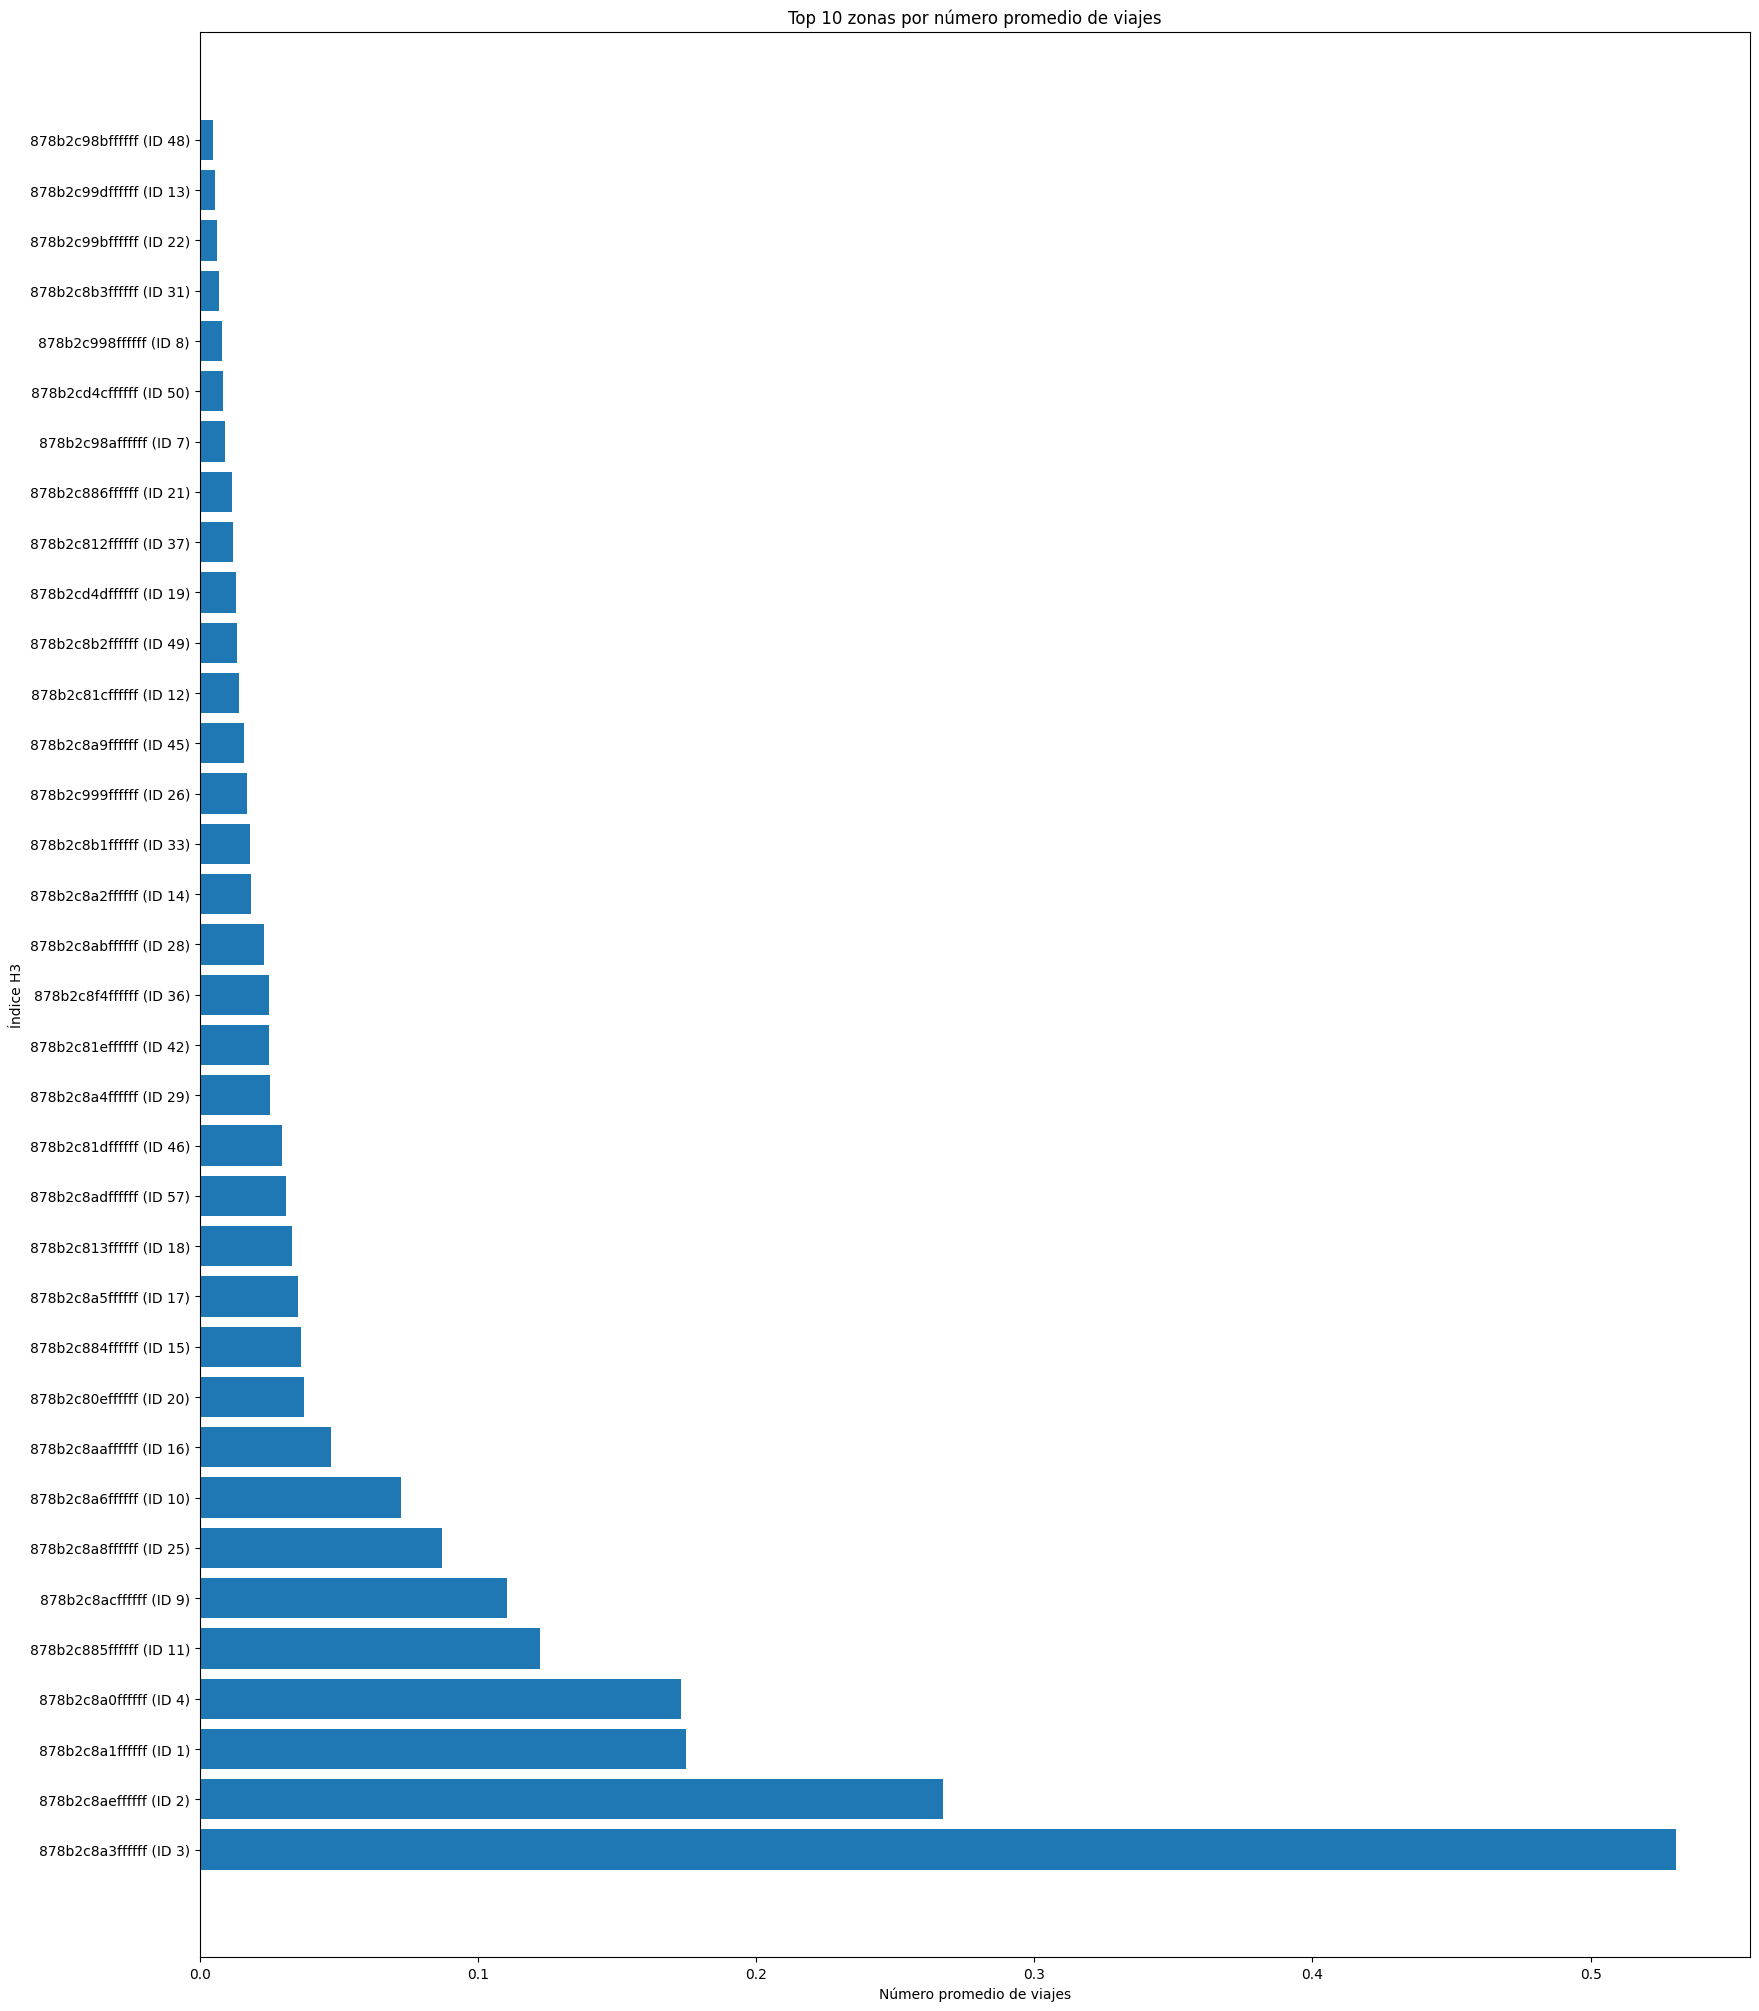

In [46]:
# Agrupar por 'h3_index' y calcular el promedio de 'origin_request_count' para cada índice
average_trips_per_zone = df_final.groupBy('h3_index').agg(avg('origin_request_count').alias('average_trips'))

# Ordenar por el promedio de viajes y tomar los 10 principales
top_10_zones = total_trips_per_zone.orderBy('average_trips', ascending=False).limit(35)

# Recopilar los datos de PySpark DataFrame y convertirlos a listas de Python
h3_index_data = top_10_zones.select('h3_index', 'id').collect()
average_trips_data = top_10_zones.select('average_trips').collect()

# Extraer los valores de las listas
h3_index_values = [f"{row['h3_index']} (ID {row['id']})" for row in h3_index_data]
average_trips_values = [row['average_trips'] for row in average_trips_data]


# Crear el gráfico de barras horizontal
fig, ax = plt.subplots(figsize=(20, 25))
ax.barh(h3_index_values, average_trips_values)

# Personalizar la visualización
ax.set_xlabel('Número promedio de viajes')
ax.set_ylabel('Índice H3')
ax.set_title('Top 10 zonas por número promedio de viajes')

# Mostrar el gráfico
plt.show()


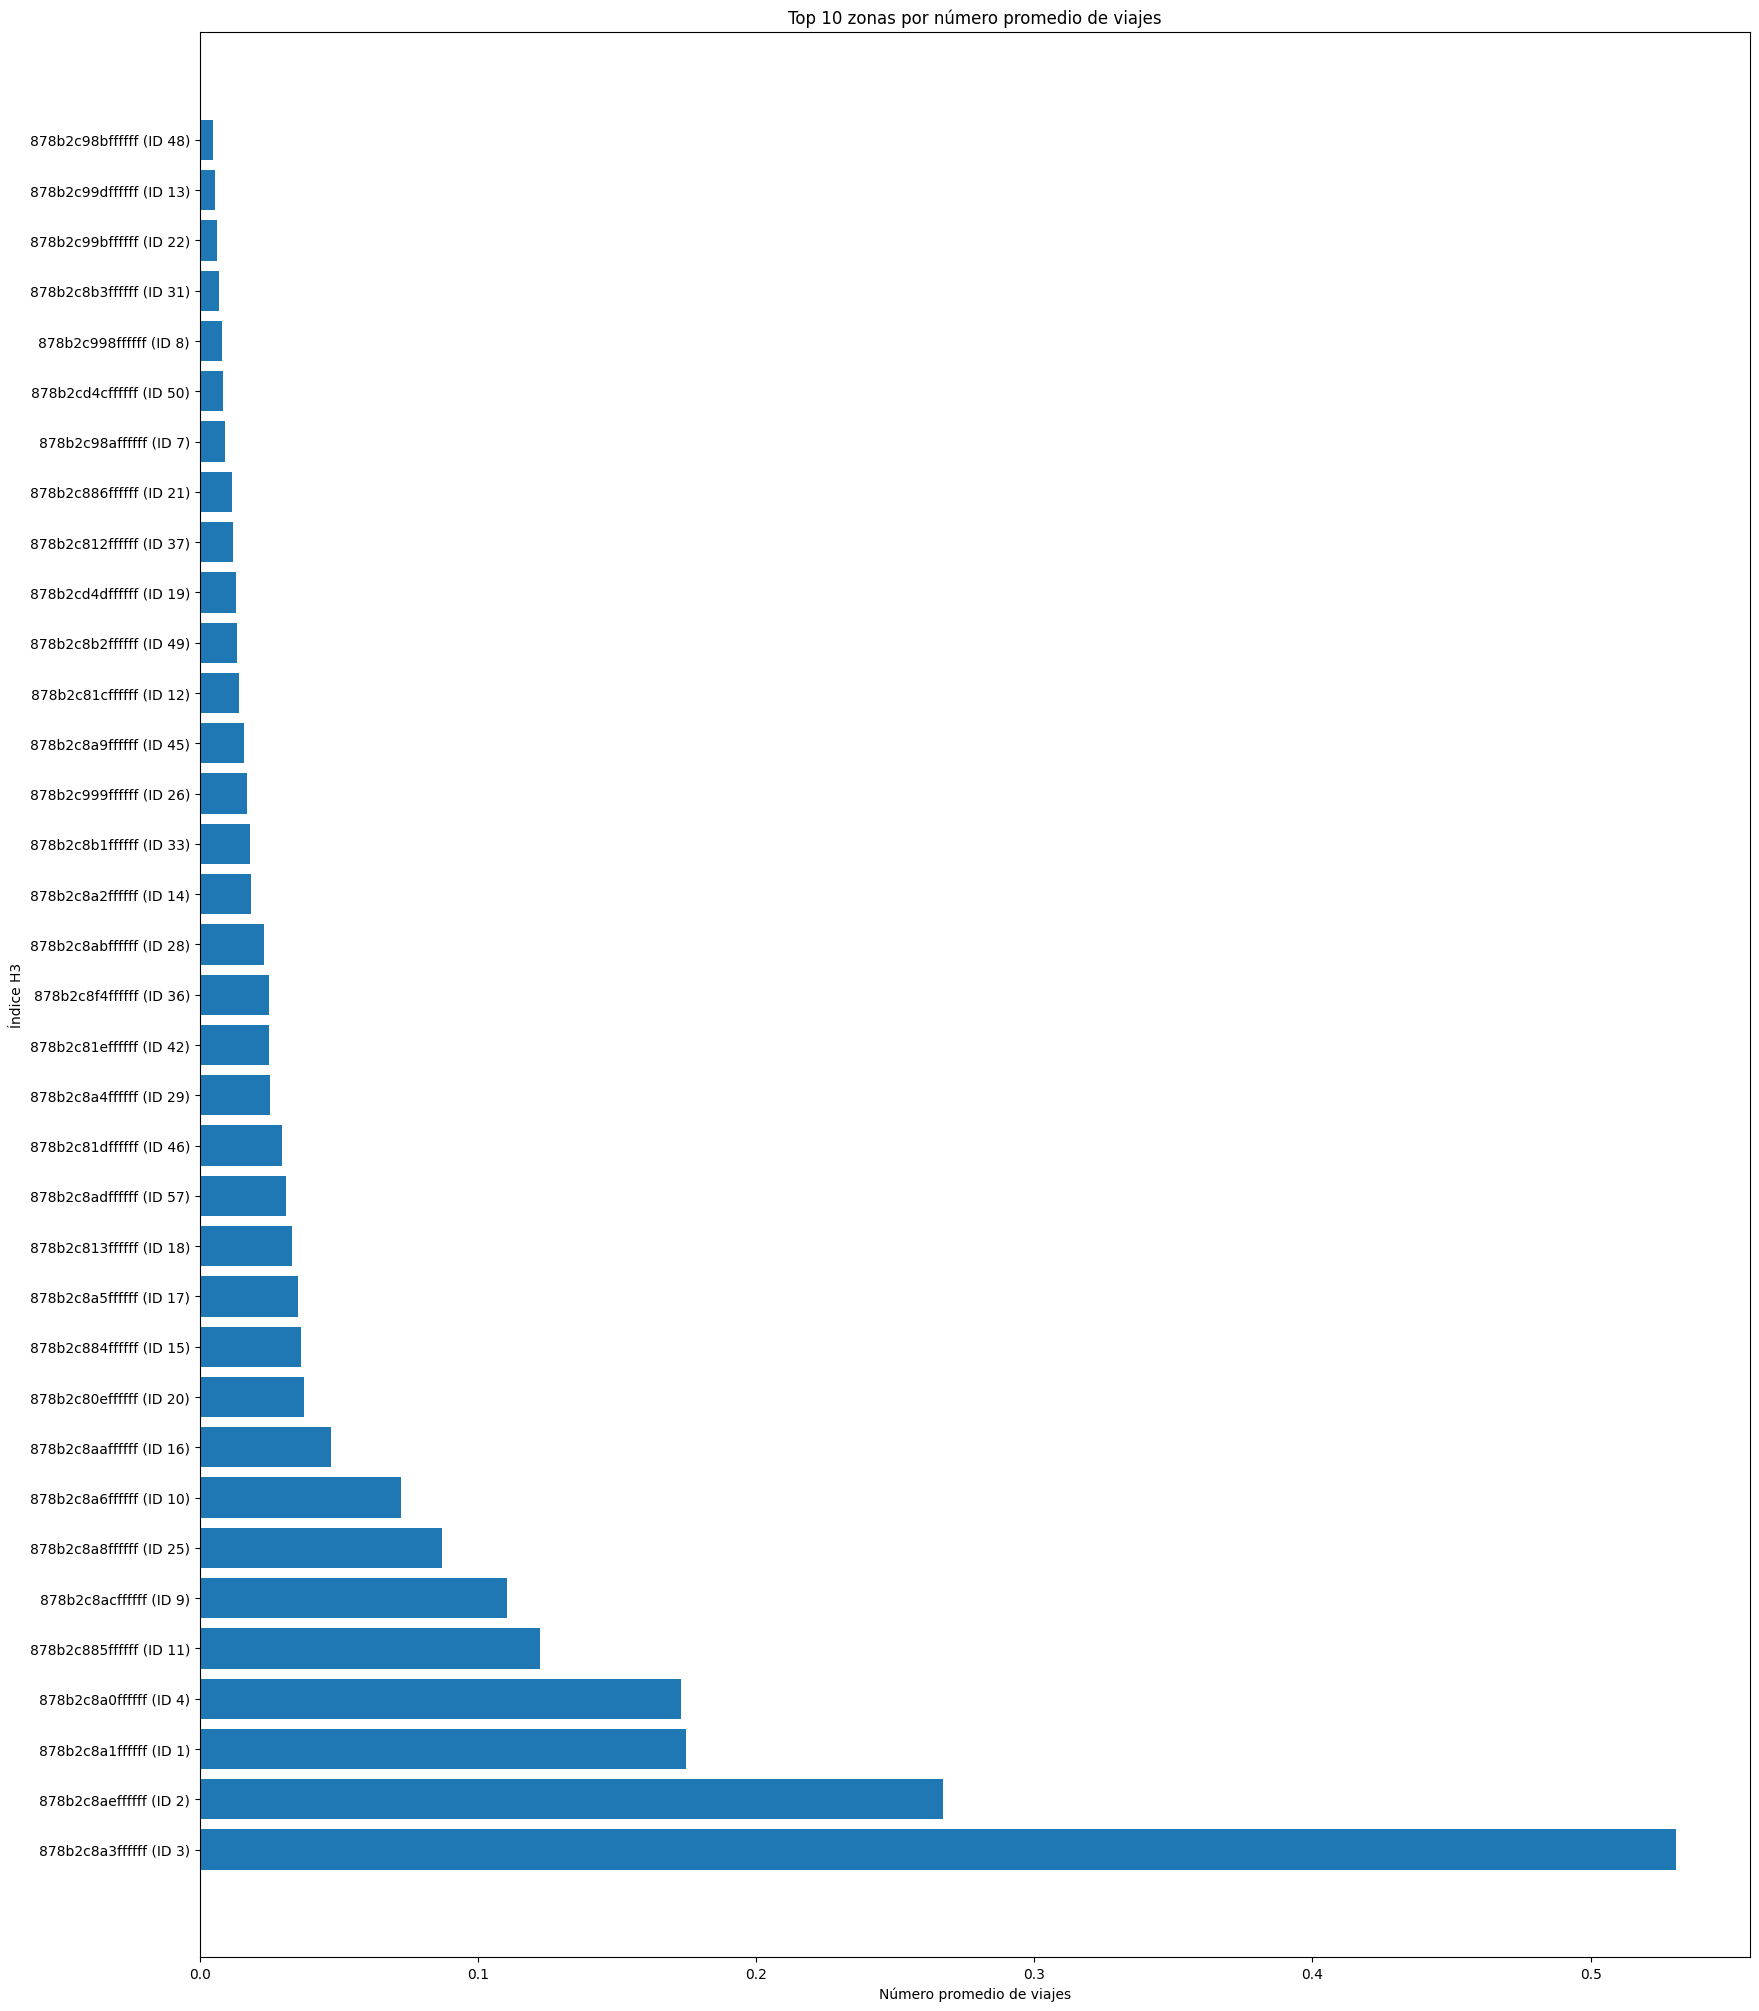

In [47]:
# Agrupar por 'h3_index' y calcular el promedio de 'origin_request_count' para cada índice
average_trips_per_zone = df_final.groupBy('h3_index').agg(avg('destination_request_count').alias('average_trips'))

# Ordenar por el promedio de viajes y tomar los 10 principales
top_10_zones = total_trips_per_zone.orderBy('average_trips', ascending=False).limit(35)

# Recopilar los datos de PySpark DataFrame y convertirlos a listas de Python
h3_index_data = top_10_zones.select('h3_index', 'id').collect()
average_trips_data = top_10_zones.select('average_trips').collect()

# Extraer los valores de las listas
h3_index_values = [f"{row['h3_index']} (ID {row['id']})" for row in h3_index_data]
average_trips_values = [row['average_trips'] for row in average_trips_data]


# Crear el gráfico de barras horizontal
fig, ax = plt.subplots(figsize=(20, 25))
ax.barh(h3_index_values, average_trips_values)

# Personalizar la visualización
ax.set_xlabel('Número promedio de viajes')
ax.set_ylabel('Índice H3')
ax.set_title('Top 10 zonas por número promedio de viajes')

# Mostrar el gráfico
plt.show()


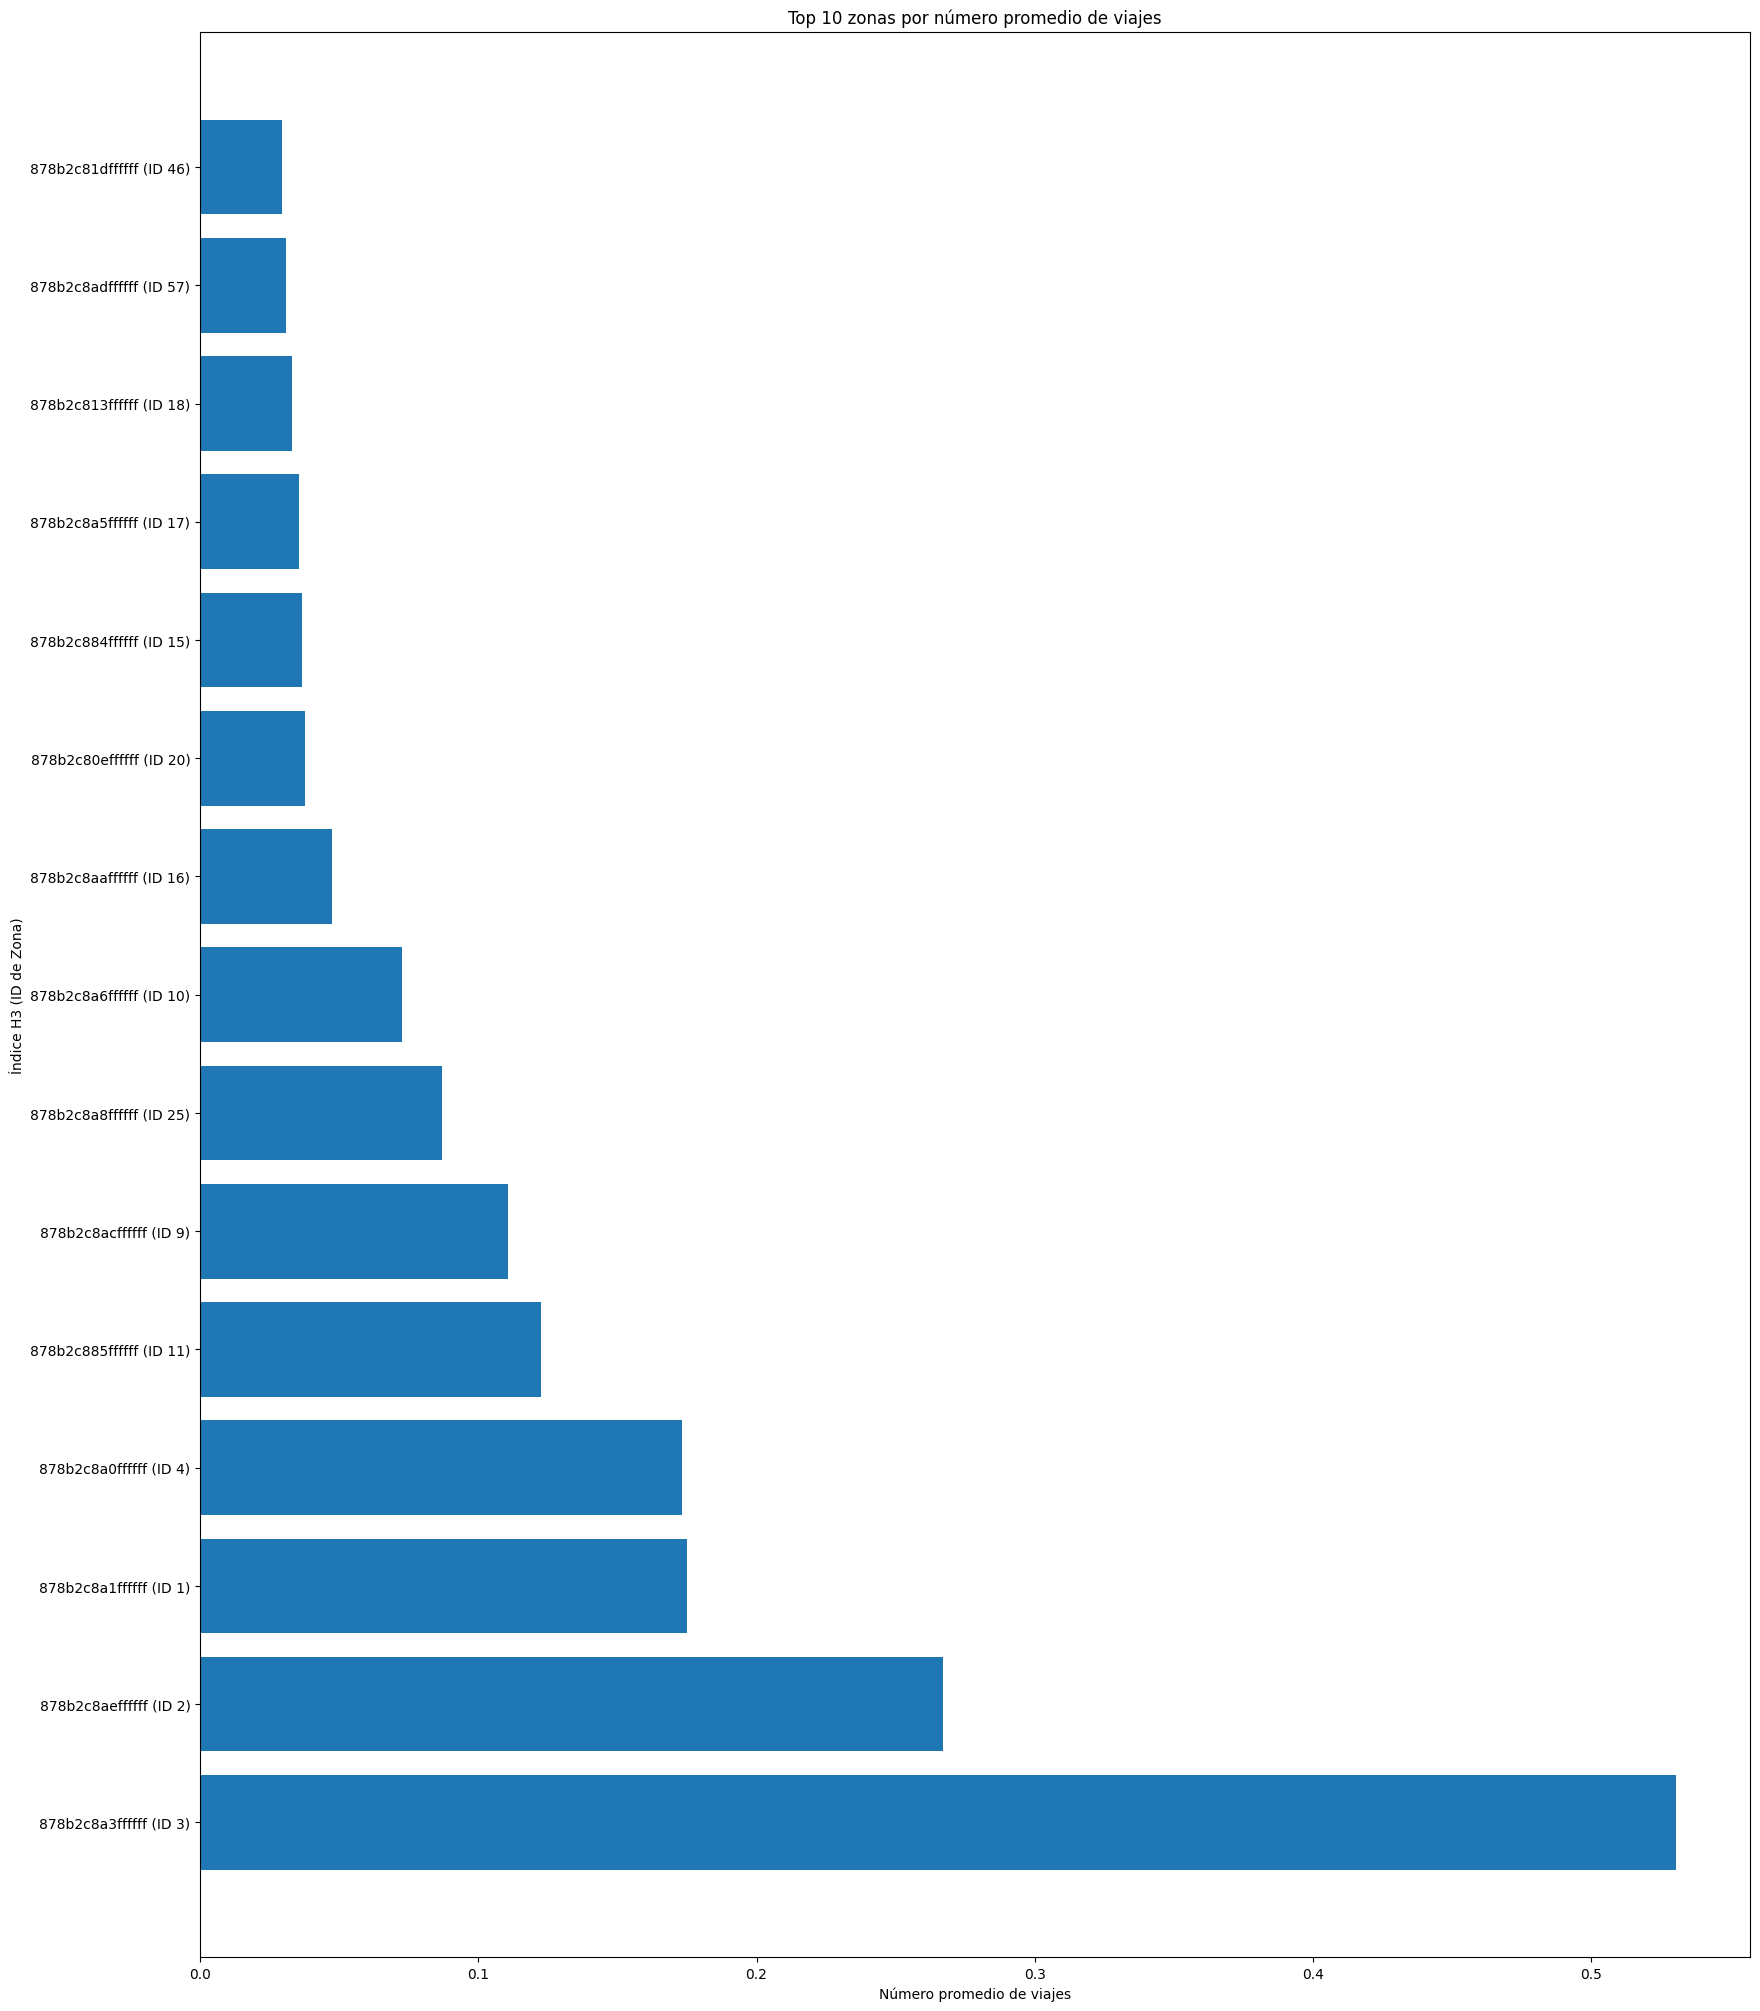

In [41]:
# Agrupar por 'h3_index' y calcular la suma total y el recuento de solicitudes de origen y destino
total_trips_per_zone = df_final.groupBy('h3_index', 'id').agg(sum('origin_request_count').alias('total_origin_trips'),
                                                                    sum('destination_request_count').alias('total_destination_trips'),
                                                                    count('*').alias('total_trips_count'))

# Calcular la suma total de viajes sumando las solicitudes de origen y destino
total_trips_per_zone = total_trips_per_zone.withColumn('total_trips', col('total_origin_trips') + col('total_destination_trips'))

# Calcular el promedio dividiendo la suma total entre el recuento total
total_trips_per_zone = total_trips_per_zone.withColumn('average_trips', col('total_trips') / col('total_trips_count'))

# Ordenar por el promedio de viajes y tomar los 10 principales
top_10_zones = total_trips_per_zone.orderBy('average_trips', ascending=False).limit(15)

# Recopilar los datos de PySpark DataFrame y convertirlos a listas de Python
h3_index_data = top_10_zones.select('h3_index', 'id').collect()
average_trips_data = top_10_zones.select('average_trips').collect()

# Extraer los valores de las listas
h3_index_values = [f"{row['h3_index']} (ID {row['id']})" for row in h3_index_data]
average_trips_values = [row['average_trips'] for row in average_trips_data]

# Crear el gráfico de barras horizontal
fig, ax = plt.subplots(figsize=(20, 25))
ax.barh(h3_index_values, average_trips_values)

# Personalizar la visualización
ax.set_xlabel('Número promedio de viajes')
ax.set_ylabel('Índice H3 (ID de Zona)')
ax.set_title('Top 10 zonas por número promedio de viajes')

# Mostrar el gráfico
plt.show()


In [48]:
dfSpark = spark.read.csv("file:///" + temporal_serie_data, header=True, inferSchema=True)
df = dfSpark.withColumn('hourly_timestamp', F.date_format('hourly_timestamp', 'yyyy-MM-dd HH:mm:ss'))
df = df.toPandas()
# Convierte la columna 'hourly_timestamp' a formato de fecha en pandas
df['hourly_timestamp'] = pd.to_datetime(df['hourly_timestamp'])

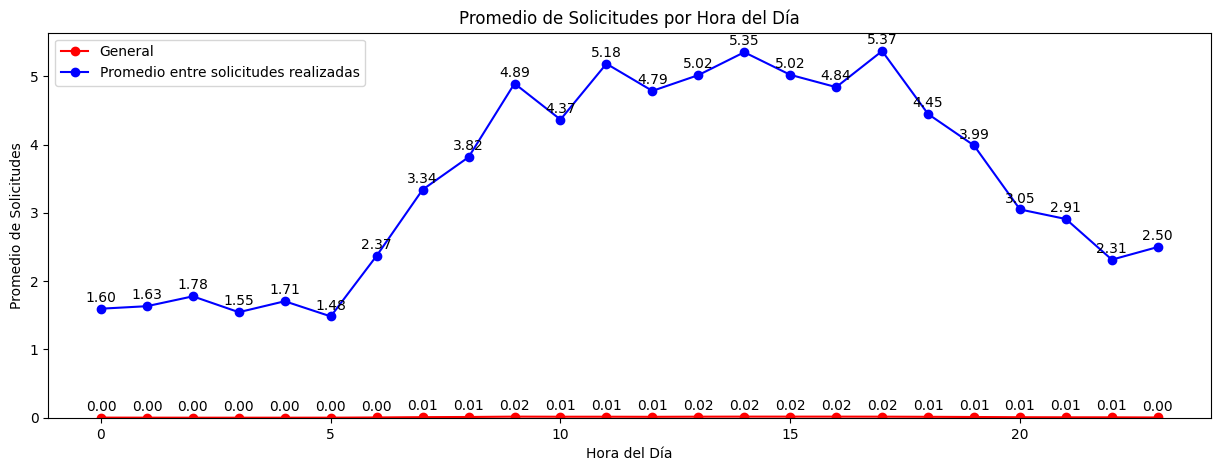

In [49]:
filtered_df = df[(df['origin_request_count'] != 0)]

# Agrupar por hora y calcular el promedio de solicitudes
hourly_average = df.groupby(df['hourly_timestamp'].dt.hour)['origin_request_count'].mean()
hourly_average_without_zero = filtered_df.groupby(filtered_df['hourly_timestamp'].dt.hour)['origin_request_count'].mean()

# Crear el gráfico de líneas para horas
plt.figure(figsize=(15, 5))
plt.plot(hourly_average.index, hourly_average, marker='o', linestyle='-', color='red', label='General')
plt.plot(hourly_average_without_zero.index, hourly_average_without_zero, marker='o', linestyle='-', color='blue', label='Promedio entre solicitudes realizadas')

# Agregar etiquetas en cada punto
for i, txt in enumerate(hourly_average):
    plt.annotate(f'{txt:.2f}', (hourly_average.index[i], txt), textcoords="offset points", xytext=(0, 5), ha='center')

for i, txt in enumerate(hourly_average_without_zero):
    plt.annotate(f'{txt:.2f}', (hourly_average_without_zero.index[i], txt), textcoords="offset points", xytext=(0, 5), ha='center')

plt.title('Promedio de Solicitudes por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Promedio de Solicitudes')
plt.ylim(bottom=0)
plt.legend()
plt.show()

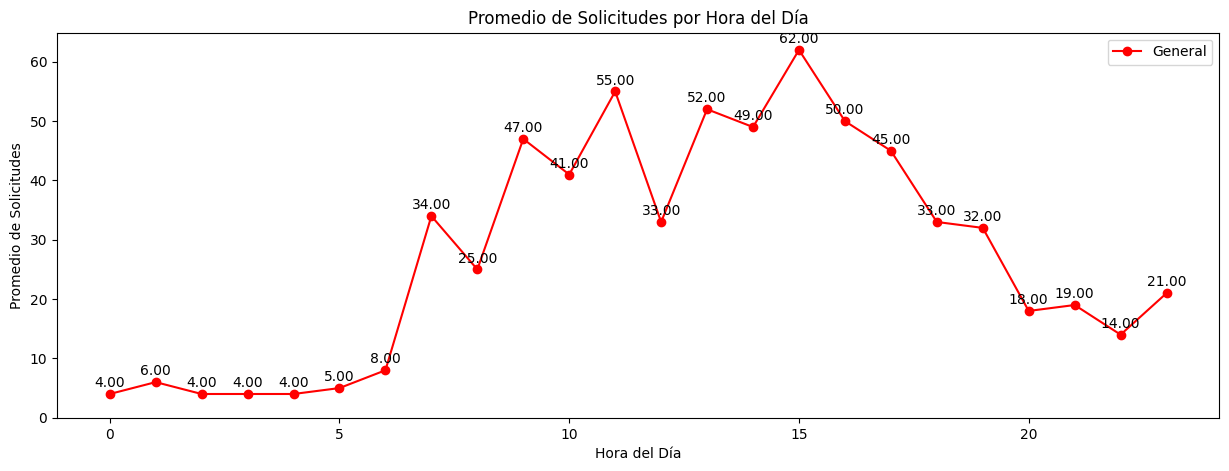

In [50]:
filtered_df = df[(df['origin_request_count'] != 0)]

# Agrupar por hora y calcular el promedio de solicitudes
hourly_average = df.groupby(df['hourly_timestamp'].dt.hour)['origin_request_count'].max()
hourly_average_without_zero = filtered_df.groupby(filtered_df['hourly_timestamp'].dt.hour)['origin_request_count'].max()

# Agrupar por hora y calcular el promedio de solicitudes
hourly_averaged = df.groupby(df['hourly_timestamp'].dt.hour)['destination_request_count'].max()
hourly_average_without_zerod = filtered_df.groupby(filtered_df['hourly_timestamp'].dt.hour)['destination_request_count'].max()

# Crear el gráfico de líneas para horas
plt.figure(figsize=(15, 5))
plt.plot(hourly_average.index, hourly_average, marker='o', linestyle='-', color='red', label='General')

# Agregar etiquetas en cada punto
for i, txt in enumerate(hourly_average):
    plt.annotate(f'{txt:.2f}', (hourly_average.index[i], txt), textcoords="offset points", xytext=(0, 5), ha='center')
    
plt.title('Promedio de Solicitudes por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Promedio de Solicitudes')
plt.ylim(bottom=0)
plt.legend()
plt.show()

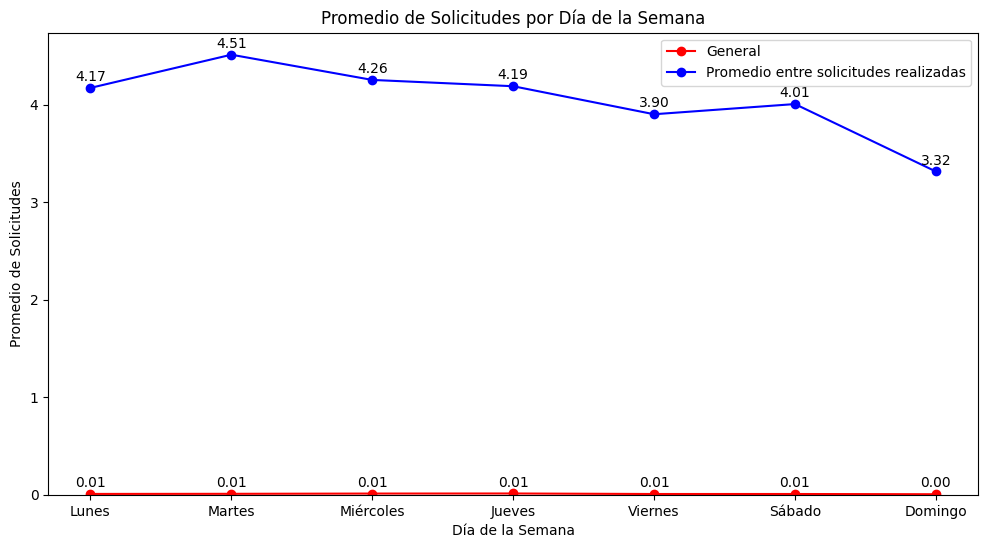

In [51]:
# Filtrar las solicitudes que no son cero
filtered_df = df[(df['origin_request_count'] != 0)]

# Agrupar por día de la semana y calcular el promedio de solicitudes
daily_average = df.groupby(df['hourly_timestamp'].dt.dayofweek)['origin_request_count'].mean()
daily_average_without_zero = filtered_df.groupby(filtered_df['hourly_timestamp'].dt.dayofweek)['origin_request_count'].mean()

# Mapear los días de la semana a nombres
days_of_week = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
daily_average.index = daily_average.index.map(lambda x: days_of_week[x])
daily_average_without_zero.index = daily_average_without_zero.index.map(lambda x: days_of_week[x])

# Crear el gráfico de líneas para días de la semana
plt.figure(figsize=(12, 6))
plt.plot(daily_average.index, daily_average, marker='o', linestyle='-', color='red', label='General')
plt.plot(daily_average_without_zero.index, daily_average_without_zero, marker='o', linestyle='-', color='blue', label='Promedio entre solicitudes realizadas')

# Agregar etiquetas en cada punto
for i, txt in enumerate(daily_average):
    plt.annotate(f'{txt:.2f}', (daily_average.index[i], txt), textcoords="offset points", xytext=(0, 5), ha='center')

for i, txt in enumerate(daily_average_without_zero):
    plt.annotate(f'{txt:.2f}', (daily_average_without_zero.index[i], txt), textcoords="offset points", xytext=(0, 5), ha='center')

plt.title('Promedio de Solicitudes por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Promedio de Solicitudes')
plt.ylim(bottom=0)
plt.legend()
plt.show()

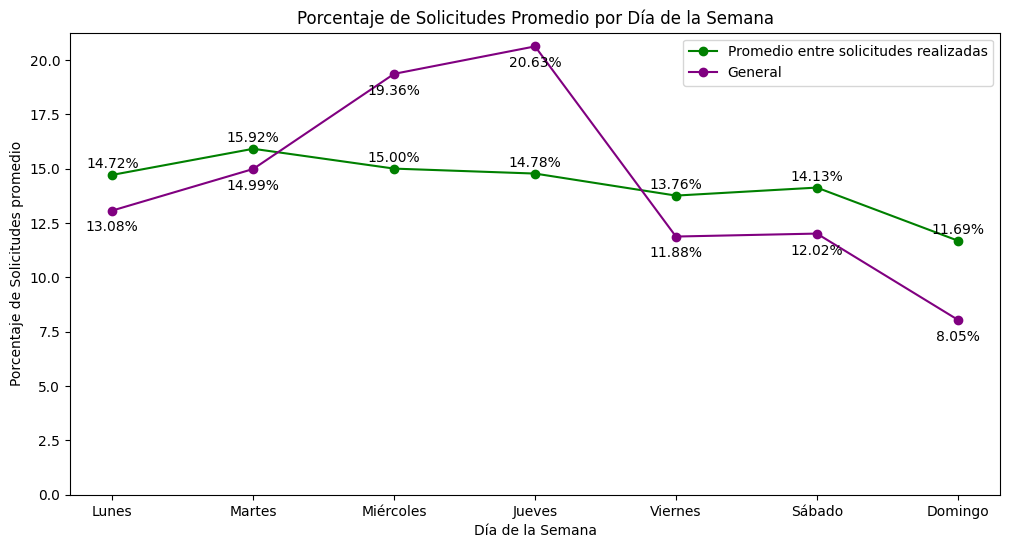

In [52]:
# Filtrar las solicitudes que no son cero
filtered_df = df[df['origin_request_count'] != 0]

# Agrupar por día de la semana y calcular el promedio de solicitudes
daily_average = df.groupby(df['hourly_timestamp'].dt.dayofweek)['origin_request_count'].mean()
daily_average_without_zero = filtered_df.groupby(filtered_df['hourly_timestamp'].dt.dayofweek)['origin_request_count'].mean()

# Calcular el total de solicitudes por día de la semana (incluyendo ceros)
total_requests_with_zeros = daily_average.sum()

# Calcular el total de solicitudes por día de la semana (sin ceros)
total_requests_no_zero = daily_average_without_zero.sum()

# Calcular el porcentaje de solicitudes de cada día al total (sin ceros)
percentage_requests_no_zero = (daily_average_without_zero / total_requests_no_zero) * 100

# Calcular el porcentaje de solicitudes de cada día al total (incluyendo ceros)
percentage_requests_with_zeros = (daily_average / total_requests_with_zeros) * 100

# Mapear los días de la semana a nombres
days_of_week = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
daily_average.index = daily_average.index.map(lambda x: days_of_week[x])
daily_average_without_zero.index = daily_average_without_zero.index.map(lambda x: days_of_week[x])
percentage_requests_no_zero.index = percentage_requests_no_zero.index.map(lambda x: days_of_week[x])
percentage_requests_with_zeros.index = percentage_requests_with_zeros.index.map(lambda x: days_of_week[x])

# Crear el gráfico de líneas para días de la semana
plt.figure(figsize=(12, 6))
plt.plot(percentage_requests_no_zero.index, percentage_requests_no_zero, marker='o', linestyle='-', color='green', label='Promedio entre solicitudes realizadas')
plt.plot(percentage_requests_with_zeros.index, percentage_requests_with_zeros, marker='o', linestyle='-', color='purple', label='General')

for i, txt in enumerate(percentage_requests_no_zero):
    plt.annotate(f'{txt:.2f}%', (percentage_requests_no_zero.index[i], txt), textcoords="offset points", xytext=(0, 5), ha='center')

for i, txt in enumerate(percentage_requests_with_zeros):
    plt.annotate(f'{txt:.2f}%', (percentage_requests_with_zeros.index[i], txt), textcoords="offset points", xytext=(0, -15), ha='center')

plt.title('Porcentaje de Solicitudes Promedio por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Porcentaje de Solicitudes promedio')
plt.ylim(bottom=0)
plt.legend()
plt.show()


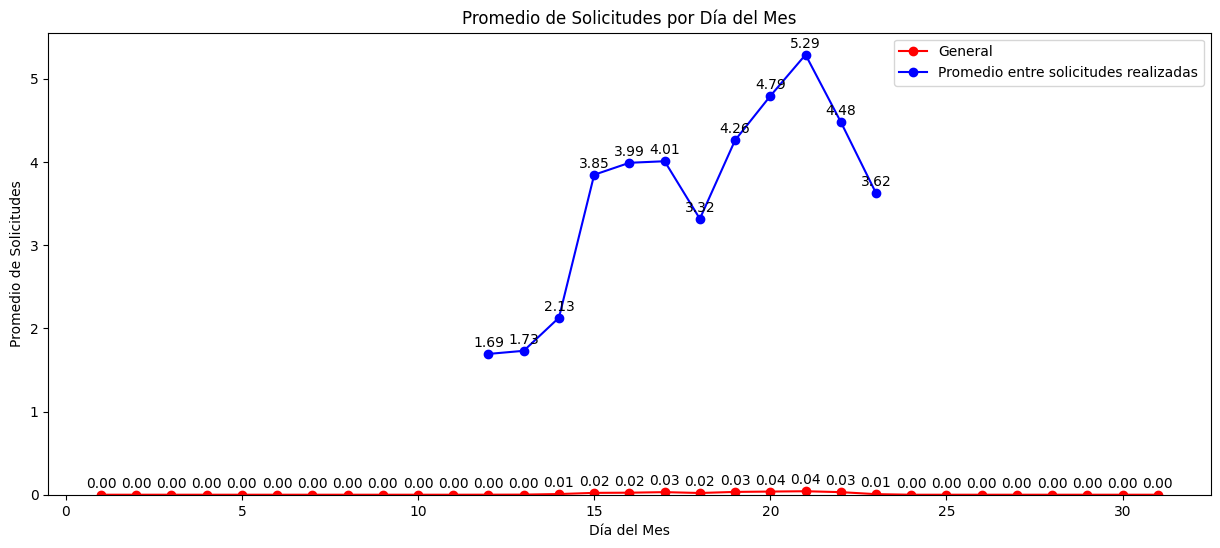

In [53]:
# Filtrar las solicitudes que no son cero
filtered_df = df[(df['origin_request_count'] != 0)]

# Agrupar por día del mes y calcular el promedio de solicitudes
daily_average = df.groupby(df['hourly_timestamp'].dt.day)['origin_request_count'].mean()
daily_average_without_zero = filtered_df.groupby(filtered_df['hourly_timestamp'].dt.day)['origin_request_count'].mean()

# Crear el gráfico de líneas para días del mes
plt.figure(figsize=(15, 6))
plt.plot(daily_average.index, daily_average, marker='o', linestyle='-', color='red', label='General')
plt.plot(daily_average_without_zero.index, daily_average_without_zero, marker='o', linestyle='-', color='blue', label='Promedio entre solicitudes realizadas')

# Agregar etiquetas en cada punto
for i, txt in enumerate(daily_average):
    plt.annotate(f'{txt:.2f}', (daily_average.index[i], txt), textcoords="offset points", xytext=(0, 5), ha='center')

for i, txt in enumerate(daily_average_without_zero):
    plt.annotate(f'{txt:.2f}', (daily_average_without_zero.index[i], txt), textcoords="offset points", xytext=(0, 5), ha='center')

plt.title('Promedio de Solicitudes por Día del Mes')
plt.xlabel('Día del Mes')
plt.ylabel('Promedio de Solicitudes')
plt.ylim(bottom=0)
plt.legend()
plt.show()

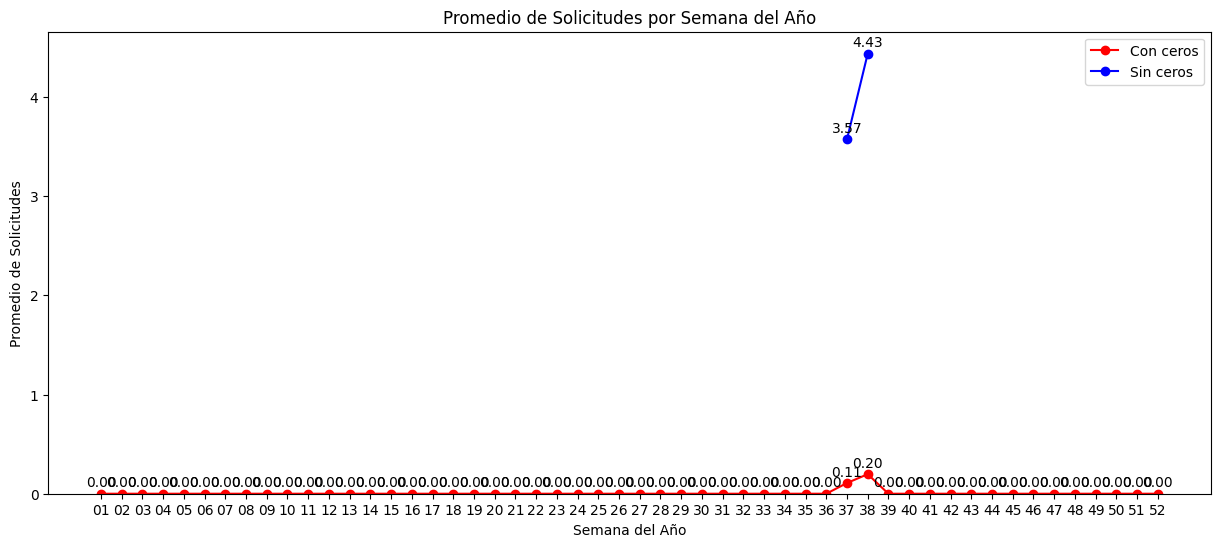

In [54]:
# Filtrar las solicitudes que no son cero
filtered_df = df[(df['origin_request_count'] != 0)]

# Agrupar por semana del año y calcular el promedio de solicitudes
weekly_average = df.groupby(df['hourly_timestamp'].dt.strftime('%U'))['origin_request_count'].mean()
weekly_average_without_zero = filtered_df.groupby(filtered_df['hourly_timestamp'].dt.strftime('%U'))['origin_request_count'].mean()

# Crear el gráfico de líneas para semanas del año
plt.figure(figsize=(15, 6))
plt.plot(weekly_average.index, weekly_average, marker='o', linestyle='-', color='red', label='Con ceros')
plt.plot(weekly_average_without_zero.index, weekly_average_without_zero, marker='o', linestyle='-', color='blue', label='Sin ceros')

# Agregar etiquetas en cada punto
for i, txt in enumerate(weekly_average):
    plt.annotate(f'{txt:.2f}', (weekly_average.index[i], txt), textcoords="offset points", xytext=(0, 5), ha='center')

for i, txt in enumerate(weekly_average_without_zero):
    plt.annotate(f'{txt:.2f}', (weekly_average_without_zero.index[i], txt), textcoords="offset points", xytext=(0, 5), ha='center')

plt.title('Promedio de Solicitudes por Semana del Año')
plt.xlabel('Semana del Año')
plt.ylabel('Promedio de Solicitudes')
plt.ylim(bottom=0)
plt.legend()
plt.show()

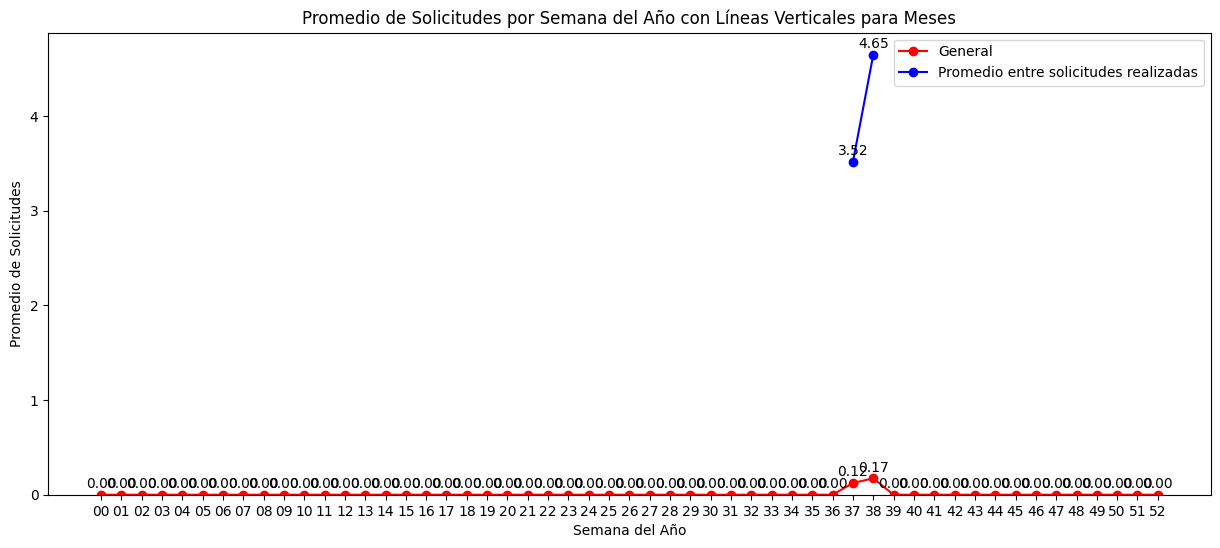

In [55]:
# Agrupar por semana del año y calcular el promedio de solicitudes
weekly_average = df.groupby(df['hourly_timestamp'].dt.strftime('%W'))['origin_request_count'].mean()
weekly_average_without_zero = filtered_df.groupby(filtered_df['hourly_timestamp'].dt.strftime('%W'))['origin_request_count'].mean()

# Crear el gráfico de líneas para semanas del año
plt.figure(figsize=(15, 6))
plt.plot(weekly_average.index, weekly_average, marker='o', linestyle='-', color='red', label='General')
plt.plot(weekly_average_without_zero.index, weekly_average_without_zero, marker='o', linestyle='-', color='blue', label='Promedio entre solicitudes realizadas')

# Agregar líneas verticales para representar los meses
month_starts = filtered_df['hourly_timestamp'][filtered_df['hourly_timestamp'].dt.is_month_start].dt.strftime('%W')
for month_start in month_starts:
    plt.axvline(x=month_start, color='gray', linestyle='--', alpha=0.5)

# Agregar etiquetas en cada punto
for i, txt in enumerate(weekly_average):
    plt.annotate(f'{txt:.2f}', (weekly_average.index[i], txt), textcoords="offset points", xytext=(0, 5), ha='center')

for i, txt in enumerate(weekly_average_without_zero):
    plt.annotate(f'{txt:.2f}', (weekly_average_without_zero.index[i], txt), textcoords="offset points", xytext=(0, 5), ha='center')

plt.title('Promedio de Solicitudes por Semana del Año con Líneas Verticales para Meses')
plt.xlabel('Semana del Año')
plt.ylabel('Promedio de Solicitudes')
plt.ylim(bottom=0)
plt.legend()
plt.show()


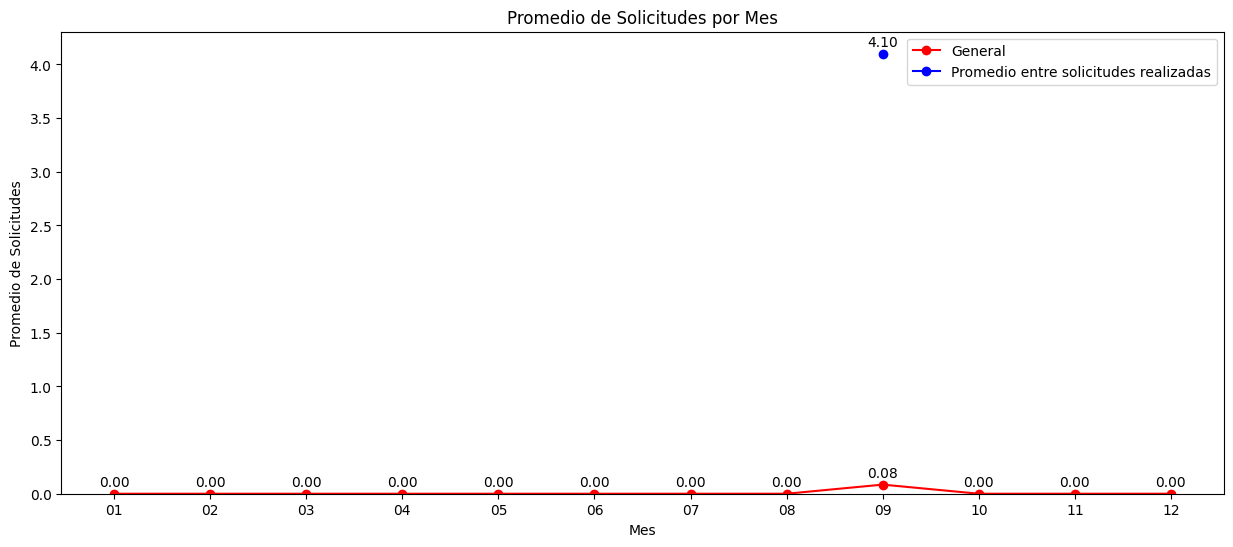

In [56]:
# Agrupar por mes y calcular el promedio de solicitudes
monthly_average = df.groupby(df['hourly_timestamp'].dt.strftime('%m'))['origin_request_count'].mean()
monthly_average_without_zero = filtered_df.groupby(filtered_df['hourly_timestamp'].dt.strftime('%m'))['origin_request_count'].mean()

# Crear el gráfico de líneas para meses
plt.figure(figsize=(15, 6))
plt.plot(monthly_average.index, monthly_average, marker='o', linestyle='-', color='red', label='General')
plt.plot(monthly_average_without_zero.index, monthly_average_without_zero, marker='o', linestyle='-', color='blue', label='Promedio entre solicitudes realizadas')

# Agregar líneas verticales para representar los meses
month_starts = filtered_df['hourly_timestamp'][filtered_df['hourly_timestamp'].dt.is_month_start].dt.strftime('%m')
for month_start in month_starts:
    plt.axvline(x=month_start, color='gray', linestyle='--', alpha=0.5)

# Agregar etiquetas en cada punto
for i, txt in enumerate(monthly_average):
    plt.annotate(f'{txt:.2f}', (monthly_average.index[i], txt), textcoords="offset points", xytext=(0, 5), ha='center')

for i, txt in enumerate(monthly_average_without_zero):
    plt.annotate(f'{txt:.2f}', (monthly_average_without_zero.index[i], txt), textcoords="offset points", xytext=(0, 5), ha='center')

plt.title('Promedio de Solicitudes por Mes')
plt.xlabel('Mes')
plt.ylabel('Promedio de Solicitudes')
plt.ylim(bottom=0)
plt.legend()
plt.show()

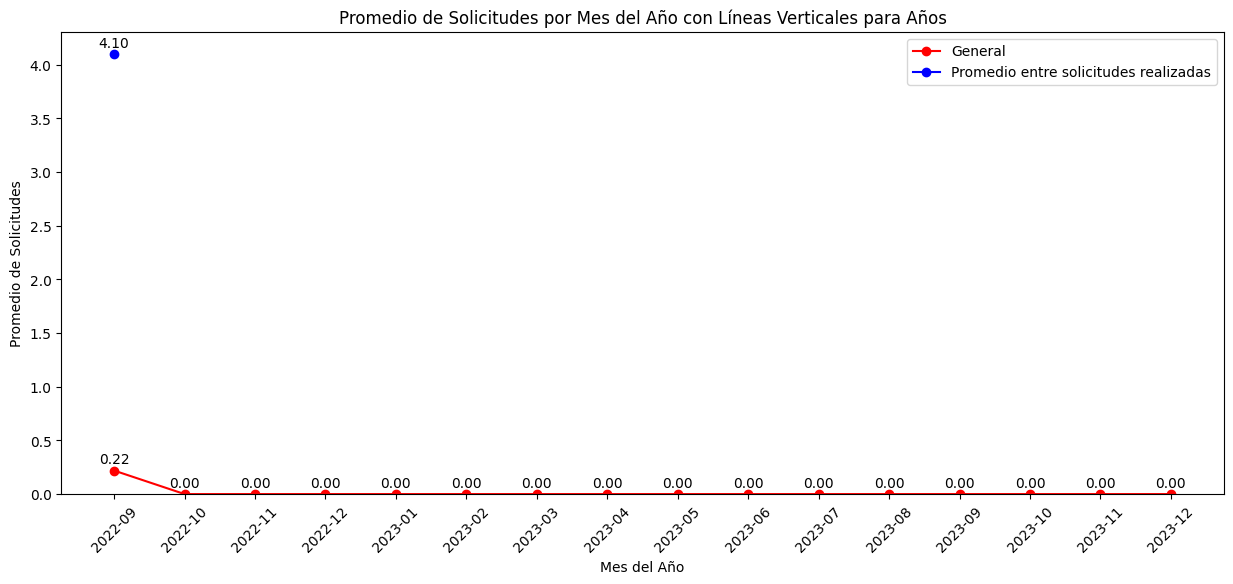

In [57]:
# Agrupar por mes del año y calcular el promedio de solicitudes
monthly_average = df.groupby(df['hourly_timestamp'].dt.strftime('%Y-%m'))['origin_request_count'].mean()
monthly_average_without_zero = filtered_df.groupby(filtered_df['hourly_timestamp'].dt.strftime('%Y-%m'))['origin_request_count'].mean()

# Crear el gráfico de líneas para meses del año
plt.figure(figsize=(15, 6))
plt.plot(monthly_average.index, monthly_average, marker='o', linestyle='-', color='red', label='General')
plt.plot(monthly_average_without_zero.index, monthly_average_without_zero, marker='o', linestyle='-', color='blue', label='Promedio entre solicitudes realizadas')

# Agregar líneas verticales para representar los años
year_starts = filtered_df['hourly_timestamp'][filtered_df['hourly_timestamp'].dt.is_year_start].dt.strftime('%Y-%m')
for year_start in year_starts:
    plt.axvline(x=year_start, color='gray', linestyle='--', alpha=0.5)

# Agregar etiquetas en cada punto
for i, txt in enumerate(monthly_average):
    plt.annotate(f'{txt:.2f}', (monthly_average.index[i], txt), textcoords="offset points", xytext=(0, 5), ha='center')

for i, txt in enumerate(monthly_average_without_zero):
    plt.annotate(f'{txt:.2f}', (monthly_average_without_zero.index[i], txt), textcoords="offset points", xytext=(0, 5), ha='center')

plt.title('Promedio de Solicitudes por Mes del Año con Líneas Verticales para Años')
plt.xlabel('Mes del Año')
plt.ylabel('Promedio de Solicitudes')
plt.ylim(bottom=0)
plt.legend()
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para una mejor legibilidad
plt.show()


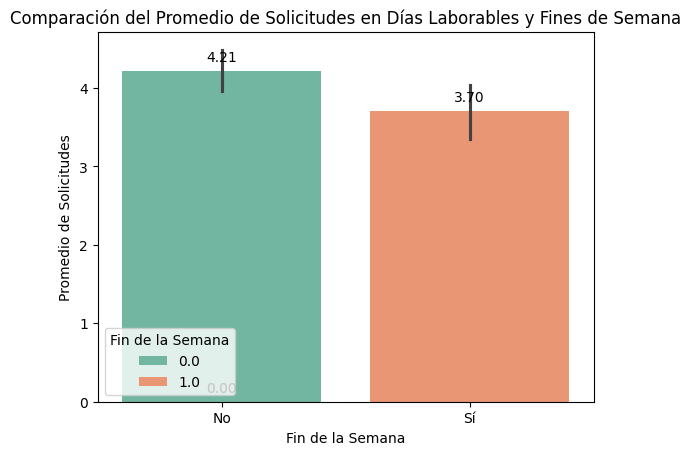

In [61]:
# Filtrar las solicitudes que no son cero
filtered_df = df[df['origin_request_count'] != 0]

# Gráfico de barras agrupadas con colores diferentes para 'isWeekend'
ax = sns.barplot(x='fin_de_semana', y='origin_request_count', data=filtered_df, hue='fin_de_semana', palette='Set2')

# Personalizar labels del eje x y del eje y
ax.set(xlabel='Fin de la Semana', ylabel='Promedio de Solicitudes')

# Agregar etiquetas a las barras
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Mapear los valores de isWeekend a 'No' o 'Sí'
ax.set_xticklabels(['No', 'Sí'])

# Título del gráfico
plt.title('Comparación del Promedio de Solicitudes en Días Laborables y Fines de Semana')

# Cambiar labels de la leyenda y título de los colores
ax.legend(title='Fin de la Semana')

# Mostrar el gráfico
plt.show()

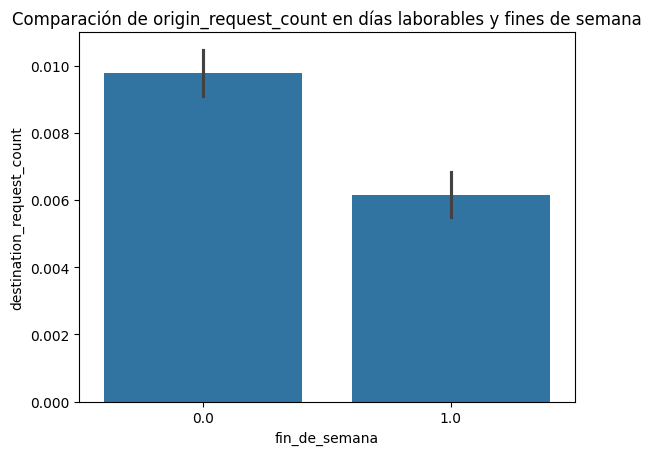

In [65]:
# Gráfico de barras agrupadas
sns.barplot(x='fin_de_semana', y='destination_request_count', data=df)
plt.title('Comparación de origin_request_count en días laborables y fines de semana')
plt.show()

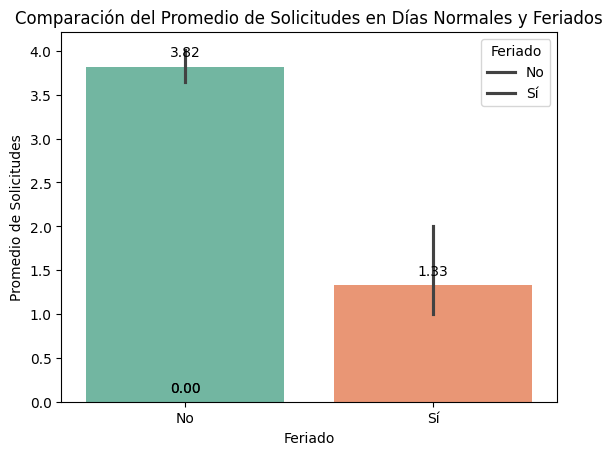

In [66]:
# Filtrar las solicitudes que no son cero
filtered_df = df[df['destination_request_count'] != 0]

# Gráfico de barras agrupadas con colores diferentes para 'Holiday_n'
ax = sns.barplot(x='Holiday_n', y='destination_request_count', data=filtered_df, hue='Holiday_n', palette='Set2')

# Personalizar labels del eje x y del eje y
ax.set(xlabel='Feriado', ylabel='Promedio de Solicitudes')

# Agregar etiquetas a las barras
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Mapear los valores de Holiday_n a 'No' o 'Sí'
ax.set_xticklabels(['No', 'Sí'])

# Título del gráfico
plt.title('Comparación del Promedio de Solicitudes en Días Normales y Feriados')

# Cambiar labels de la leyenda y título de los colores
ax.legend(title='Feriado', labels=['No', 'Sí'])

# Mostrar el gráfico
plt.show()

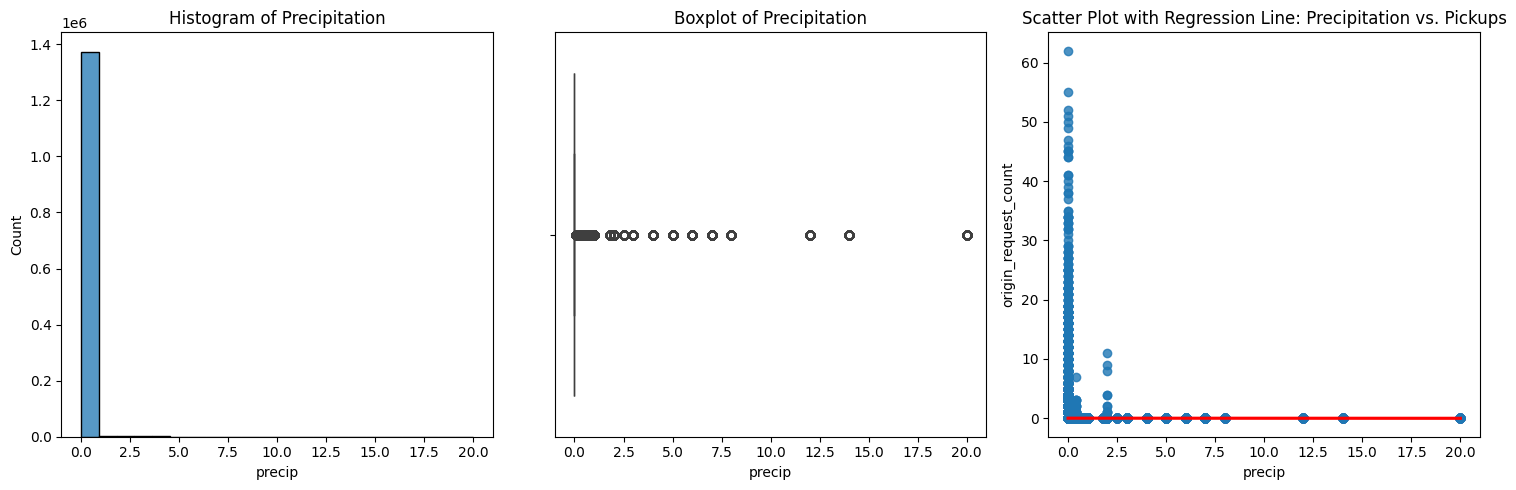

In [67]:
# Assuming your DataFrame is named df
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Histogram
sns.histplot(df['precip'], ax=ax[0])
ax[0].set_title('Histogram of Precipitation')

# Boxplot
sns.boxplot(x=df['precip'], ax=ax[1])
ax[1].set_title('Boxplot of Precipitation')

# Scatter plot with regression line
sns.regplot(x=df['precip'], y=df['origin_request_count'], ax=ax[2], line_kws={'color': 'red'})
ax[2].set_title('Scatter Plot with Regression Line: Precipitation vs. Pickups')

plt.tight_layout()
plt.show()

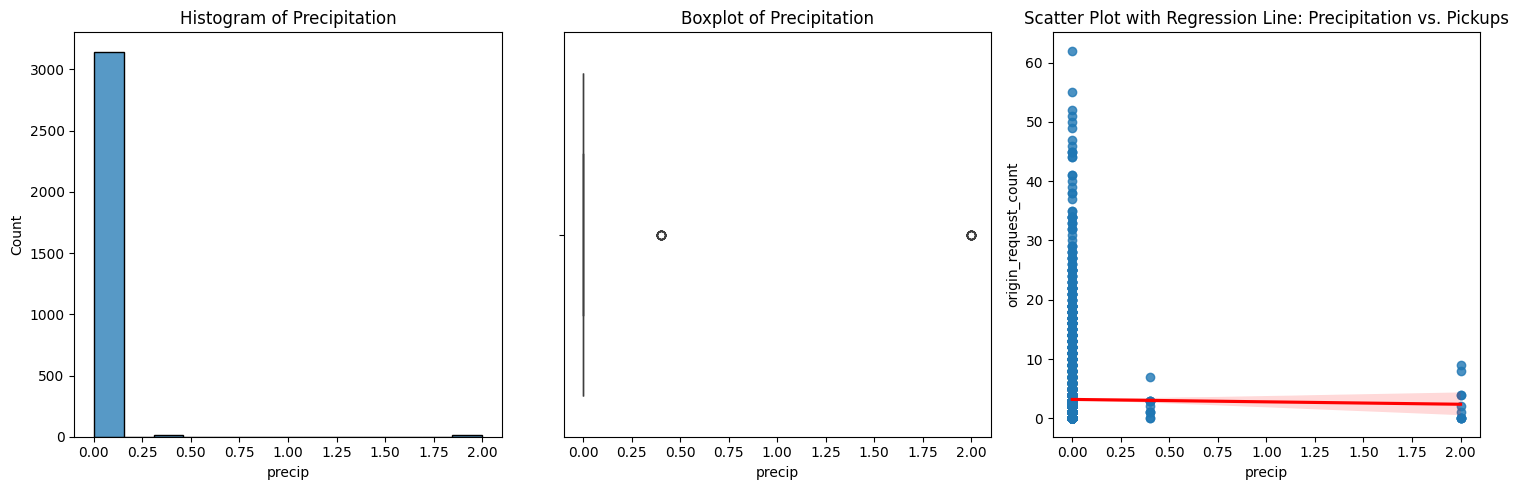

In [68]:
# Assuming your DataFrame is named df
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Histogram
sns.histplot(filtered_df['precip'], ax=ax[0])
ax[0].set_title('Histogram of Precipitation')

# Boxplot
sns.boxplot(x=filtered_df['precip'], ax=ax[1])
ax[1].set_title('Boxplot of Precipitation')

# Scatter plot with regression line
sns.regplot(x=filtered_df['precip'], y=filtered_df['origin_request_count'], ax=ax[2], line_kws={'color': 'red'})
ax[2].set_title('Scatter Plot with Regression Line: Precipitation vs. Pickups')

plt.tight_layout()
plt.show()

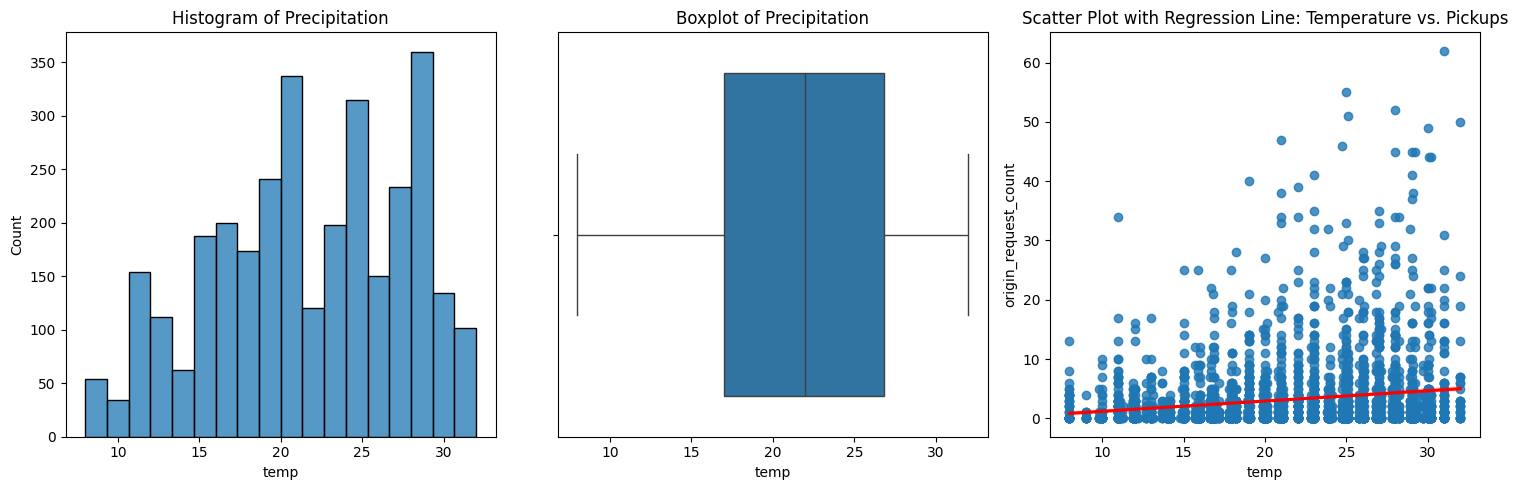

In [69]:
# Assuming your DataFrame is named df
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Histogram
sns.histplot(filtered_df['temp'], ax=ax[0])
ax[0].set_title('Histogram of Precipitation')

# Boxplot
sns.boxplot(x=filtered_df['temp'], ax=ax[1])
ax[1].set_title('Boxplot of Precipitation')

# Scatter plot with regression line and a different color
sns.regplot(x=filtered_df['temp'], y=filtered_df['origin_request_count'], ax=ax[2], line_kws={'color': 'red'})
ax[2].set_title('Scatter Plot with Regression Line: Temperature vs. Pickups')

plt.tight_layout()
plt.show()

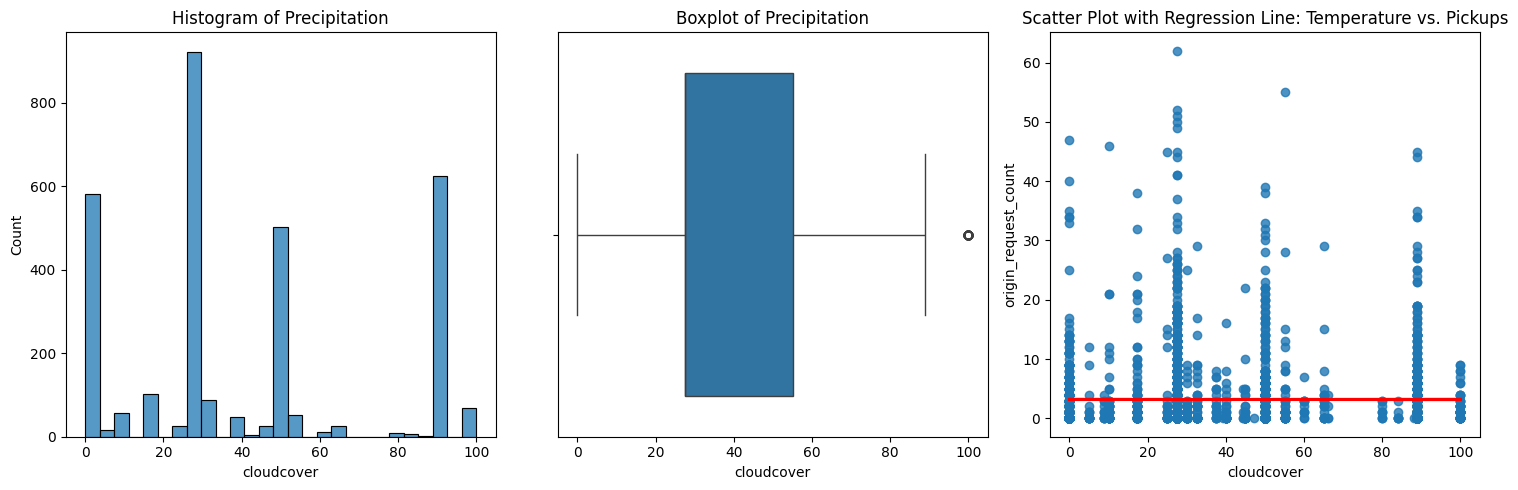

In [70]:
# Assuming your DataFrame is named df
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Histogram
sns.histplot(filtered_df['cloudcover'], ax=ax[0])
ax[0].set_title('Histogram of Precipitation')

# Boxplot
sns.boxplot(x=filtered_df['cloudcover'], ax=ax[1])
ax[1].set_title('Boxplot of Precipitation')

# Scatter plot with regression line and a different color
sns.regplot(x=filtered_df['cloudcover'], y=filtered_df['origin_request_count'], ax=ax[2], line_kws={'color': 'red'})
ax[2].set_title('Scatter Plot with Regression Line: Temperature vs. Pickups')

plt.tight_layout()
plt.show()

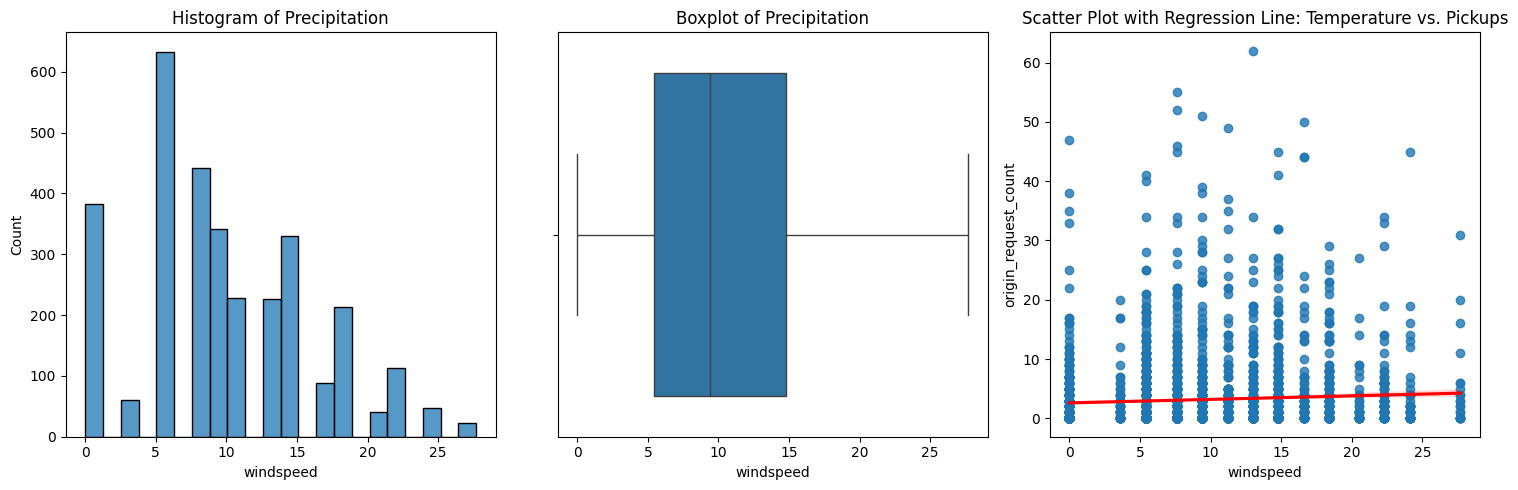

In [71]:
# Assuming your DataFrame is named df
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Histogram
sns.histplot(filtered_df['windspeed'], ax=ax[0])
ax[0].set_title('Histogram of Precipitation')

# Boxplot
sns.boxplot(x=filtered_df['windspeed'], ax=ax[1])
ax[1].set_title('Boxplot of Precipitation')

# Scatter plot with regression line and a different color
sns.regplot(x=filtered_df['windspeed'], y=filtered_df['origin_request_count'], ax=ax[2], line_kws={'color': 'red'})
ax[2].set_title('Scatter Plot with Regression Line: Temperature vs. Pickups')

plt.tight_layout()
plt.show()

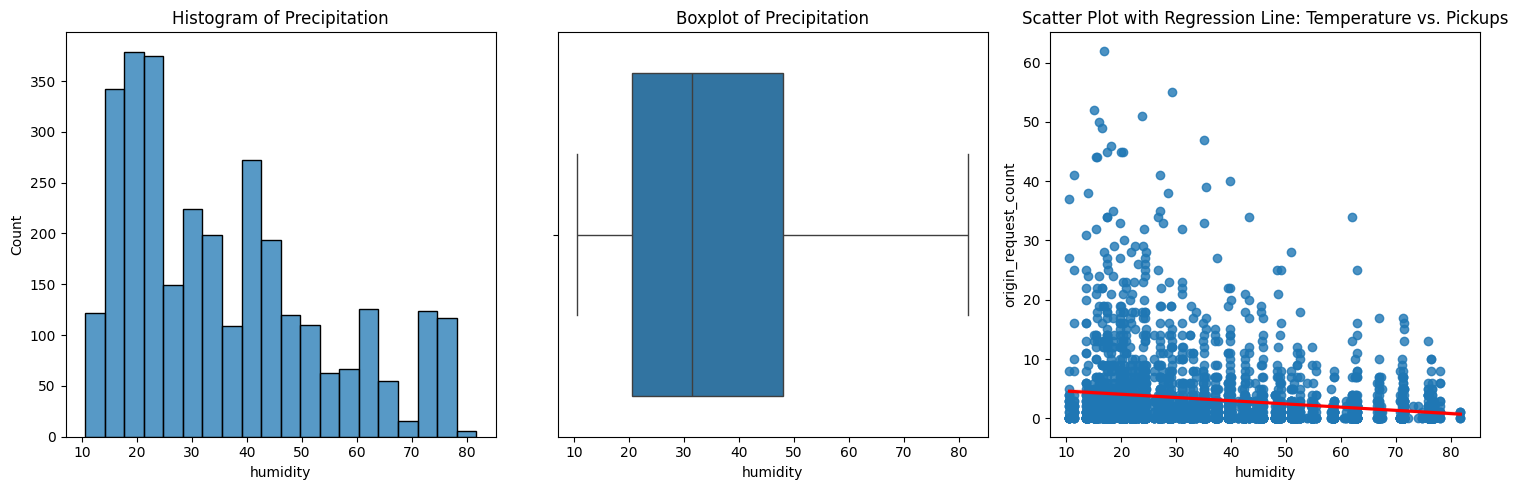

In [72]:
# Assuming your DataFrame is named df
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Histogram
sns.histplot(filtered_df['humidity'], ax=ax[0])
ax[0].set_title('Histogram of Precipitation')

# Boxplot
sns.boxplot(x=filtered_df['humidity'], ax=ax[1])
ax[1].set_title('Boxplot of Precipitation')

# Scatter plot with regression line and a different color
sns.regplot(x=filtered_df['humidity'], y=filtered_df['origin_request_count'], ax=ax[2], line_kws={'color': 'red'})
ax[2].set_title('Scatter Plot with Regression Line: Temperature vs. Pickups')

plt.tight_layout()
plt.show()

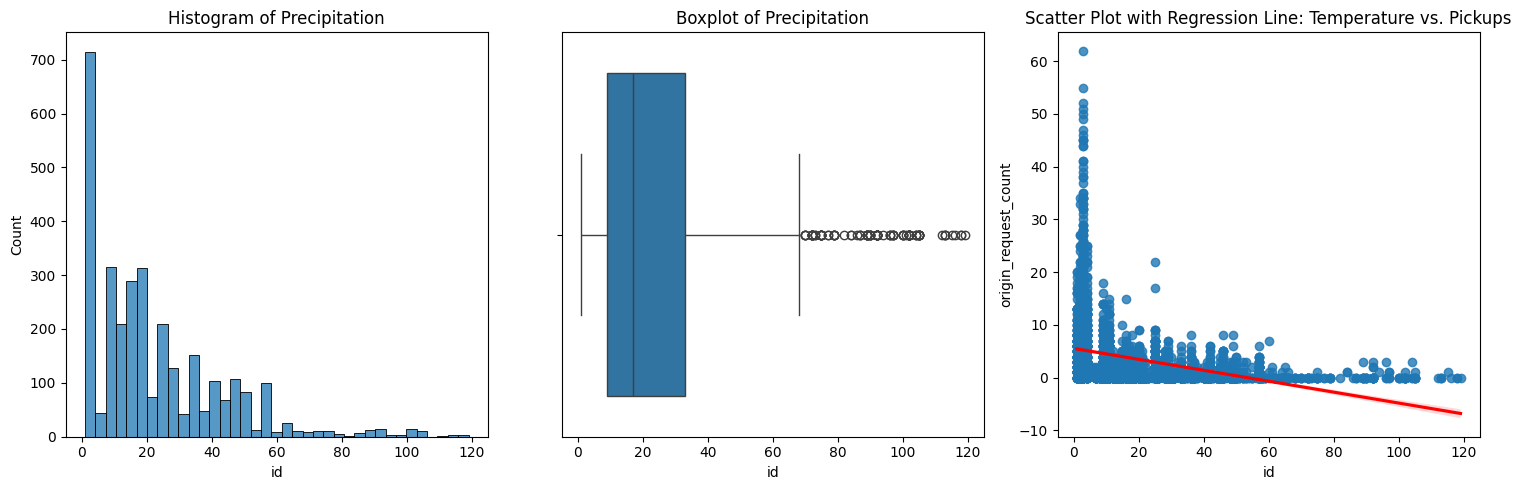

In [73]:
# Assuming your DataFrame is named df
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Histogram
sns.histplot(filtered_df['id'], ax=ax[0])
ax[0].set_title('Histogram of Precipitation')

# Boxplot
sns.boxplot(x=filtered_df['id'], ax=ax[1])
ax[1].set_title('Boxplot of Precipitation')

# Scatter plot with regression line and a different color
sns.regplot(x=filtered_df['id'], y=filtered_df['origin_request_count'], ax=ax[2], line_kws={'color': 'red'})
ax[2].set_title('Scatter Plot with Regression Line: Temperature vs. Pickups')

plt.tight_layout()
plt.show()

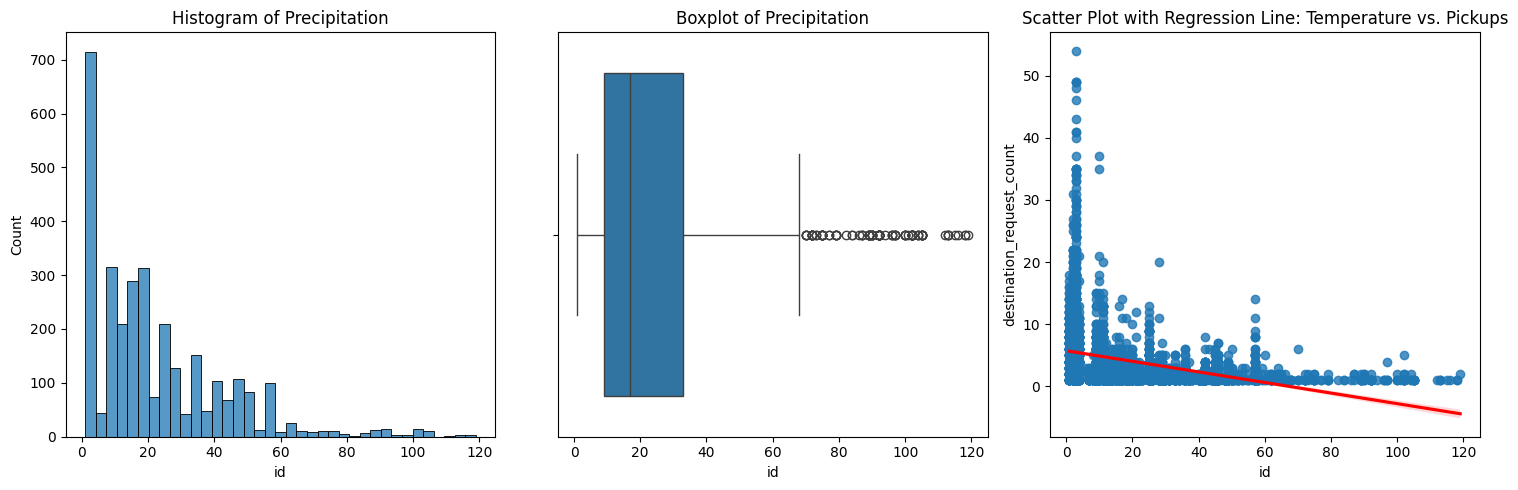

In [74]:
# Assuming your DataFrame is named df
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Histogram
sns.histplot(filtered_df['id'], ax=ax[0])
ax[0].set_title('Histogram of Precipitation')

# Boxplot
sns.boxplot(x=filtered_df['id'], ax=ax[1])
ax[1].set_title('Boxplot of Precipitation')

# Scatter plot with regression line and a different color
sns.regplot(x=filtered_df['id'], y=filtered_df['destination_request_count'], ax=ax[2], line_kws={'color': 'red'})
ax[2].set_title('Scatter Plot with Regression Line: Temperature vs. Pickups')

plt.tight_layout()
plt.show()

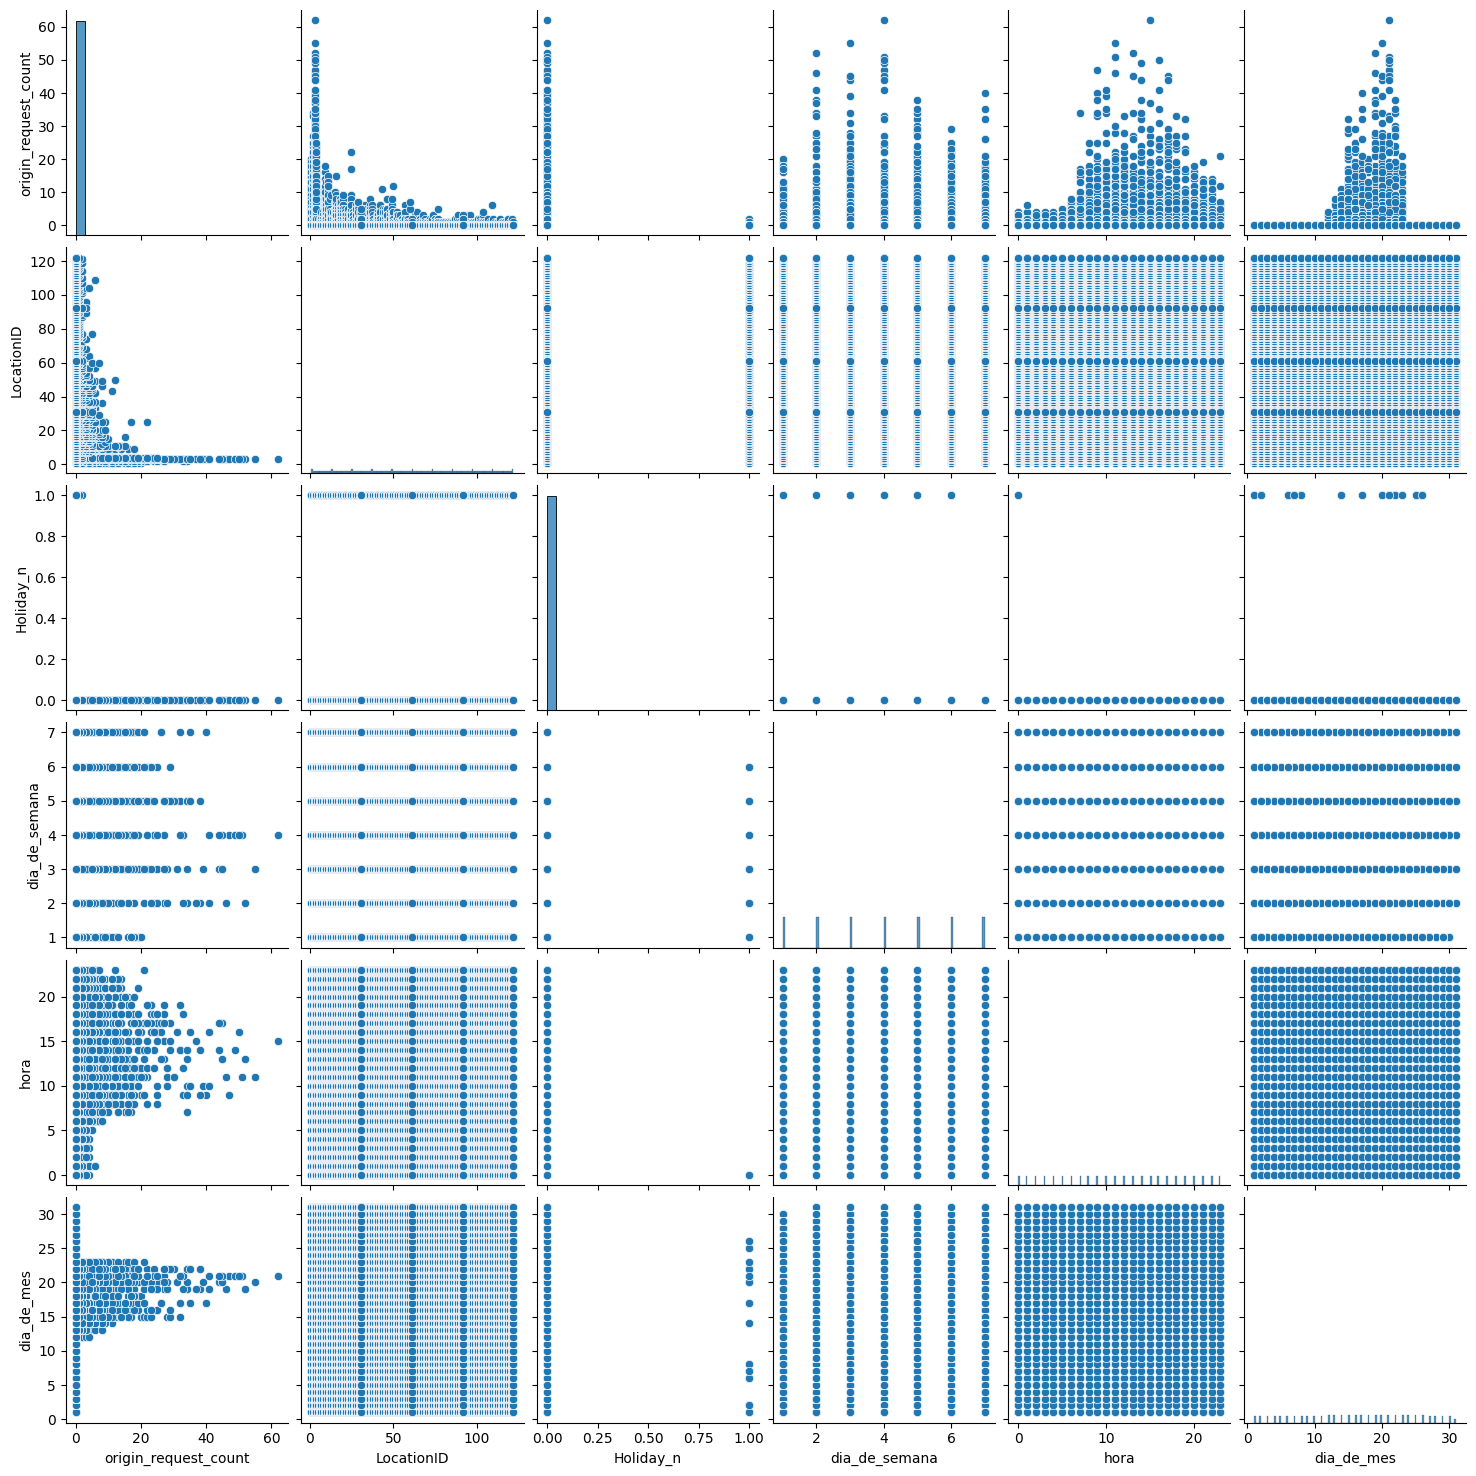

In [76]:
# Specify the variables you want to include in the pair plot
variables = ['origin_request_count', 'LocationID', 'Holiday_n','dia_de_semana', 'hora',
             'dia_de_mes']

# Create a new dataframe with only the selected variables
df_selected = df[variables]

# Create the pair plot
sns.pairplot(df_selected)

# Show the plot
plt.show()

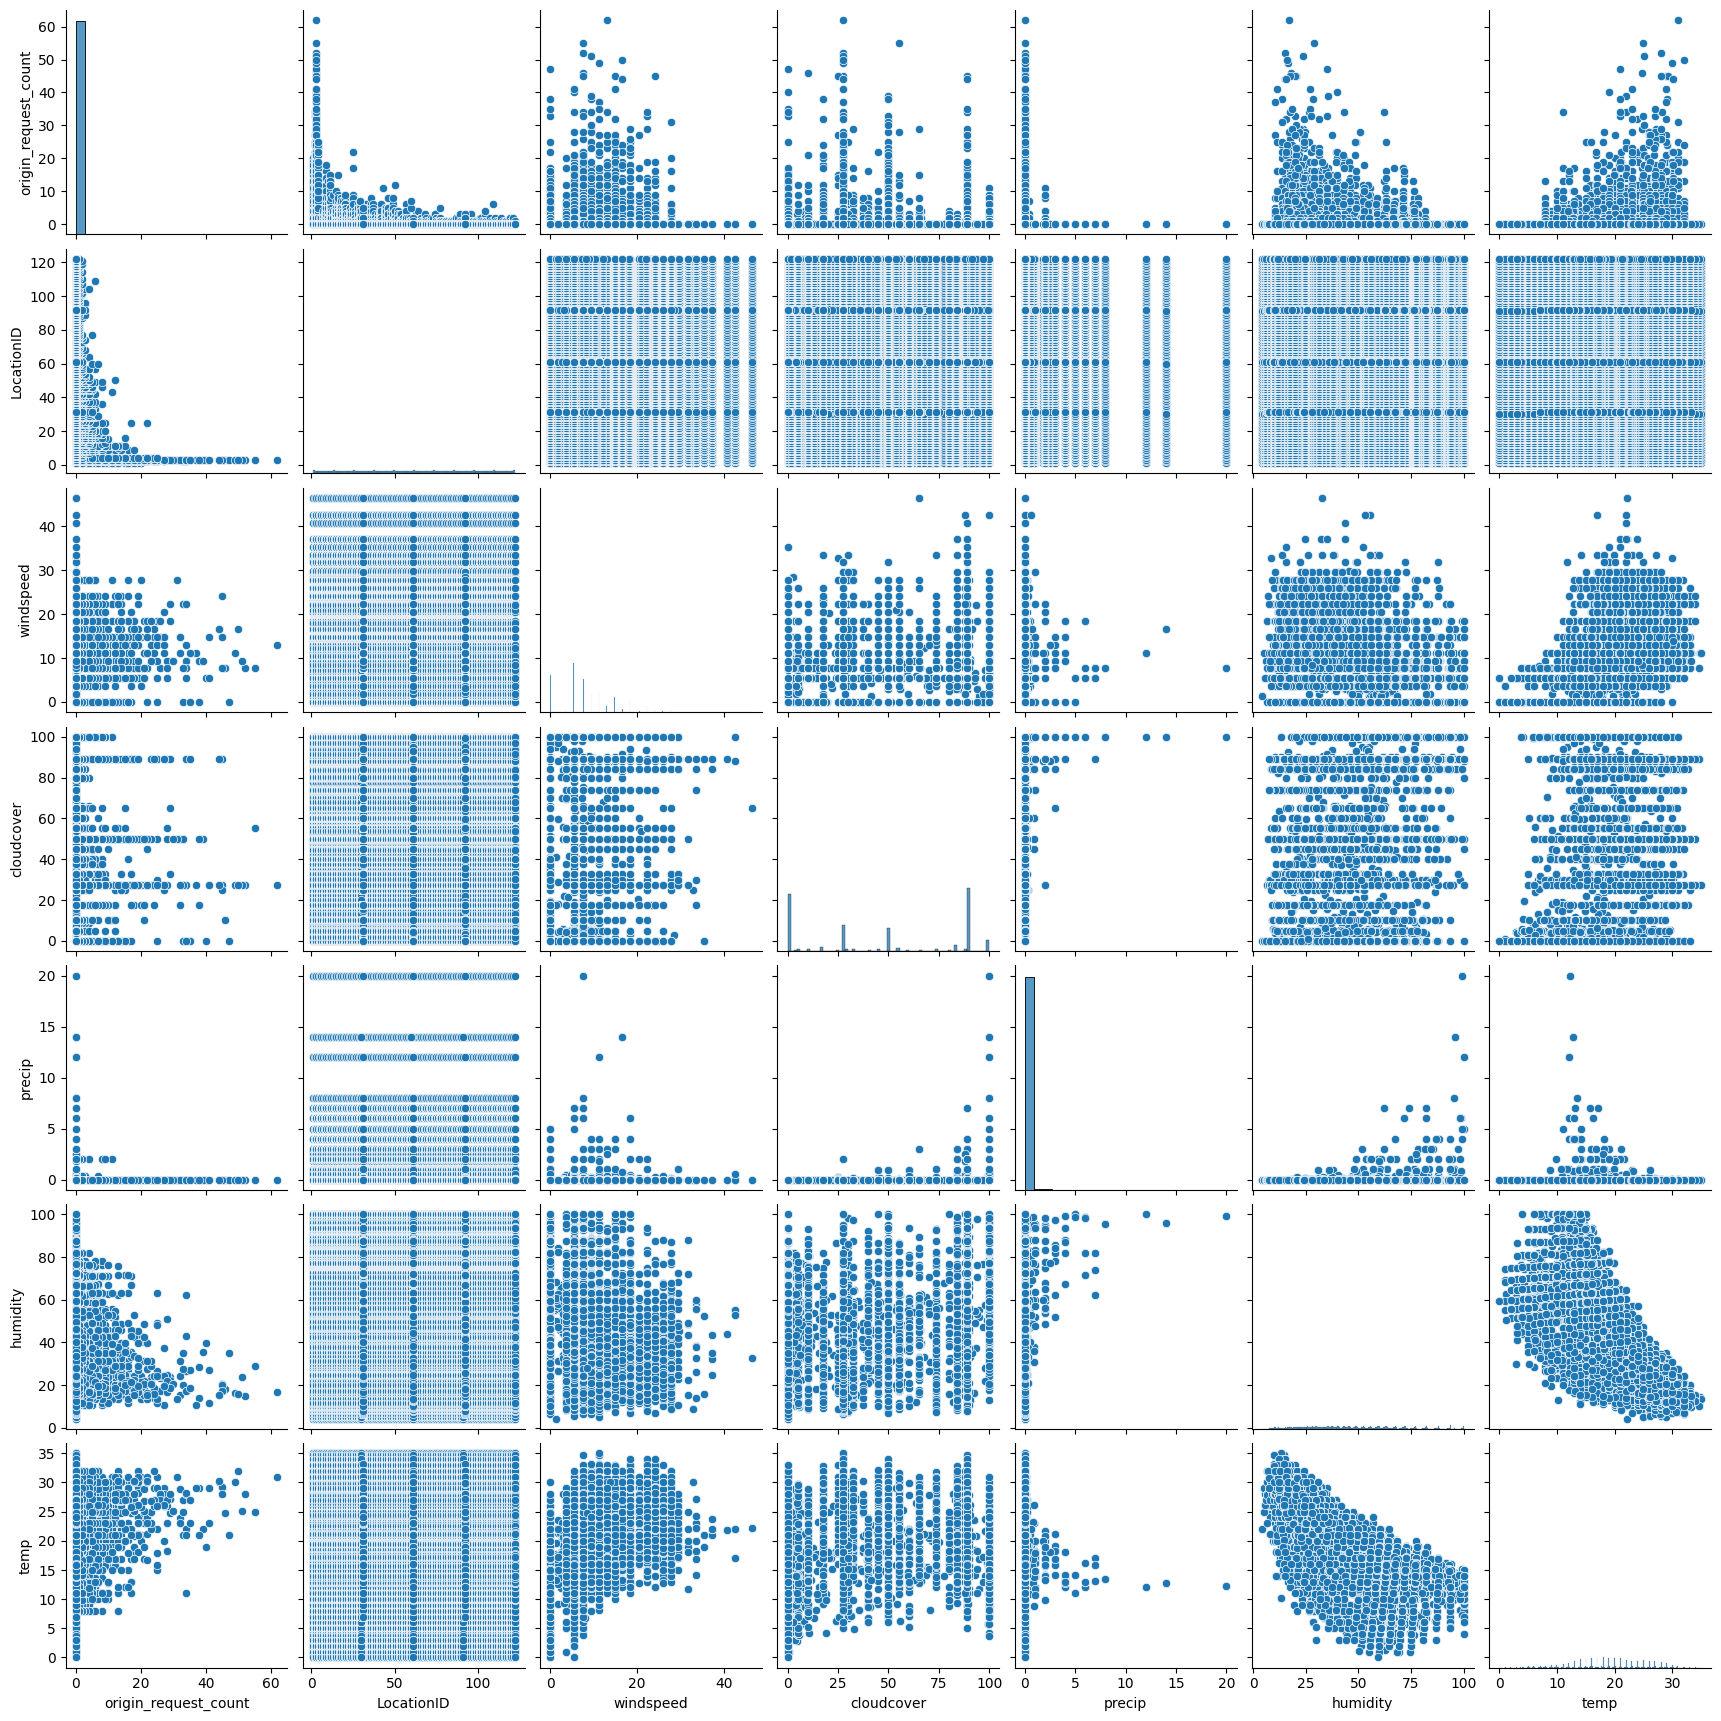

In [77]:
# Specify the variables you want to include in the pair plot
variables = ['origin_request_count', 'LocationID', 'windspeed', 'cloudcover', 'precip', 'humidity', 'temp']

# Create a new dataframe with only the selected variables
df_selected = df[variables]

# Create the pair plot
sns.pairplot(df_selected)

# Show the plot
plt.show()

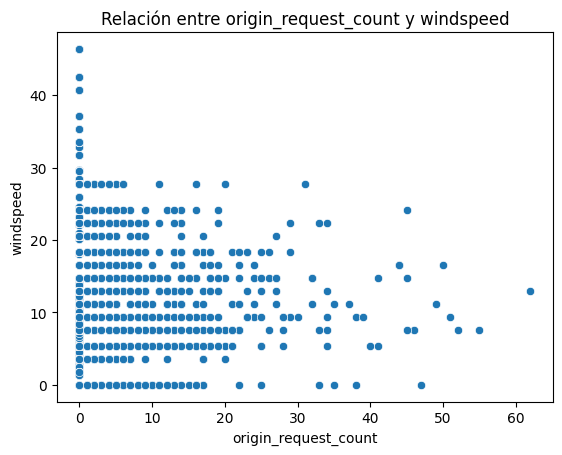

In [78]:
# Gráfico de dispersión
sns.scatterplot(x='origin_request_count', y='windspeed', data=df)
plt.title('Relación entre origin_request_count y windspeed')
plt.show()


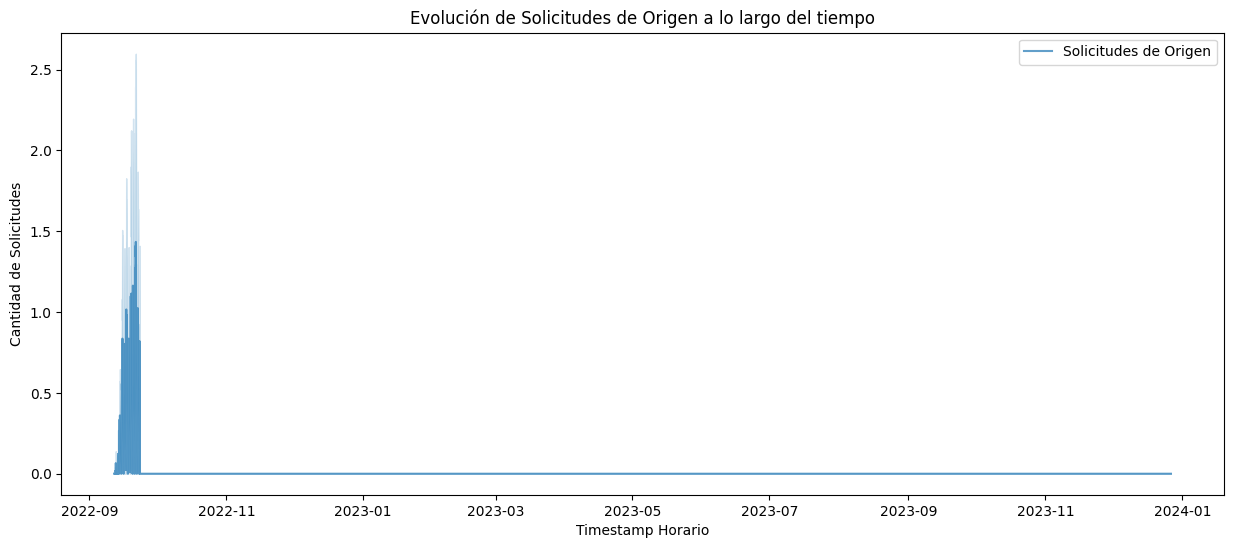

In [79]:
# Ajusta el tamaño de la figura antes de crear la gráfica
plt.figure(figsize=(15, 6))

# Crea el gráfico de línea
sns.lineplot(x='hourly_timestamp', y='origin_request_count', data=df, label='Solicitudes de Origen')

# Personaliza labels del eje x y del eje y
plt.xlabel('Timestamp Horario')
plt.ylabel('Cantidad de Solicitudes')
plt.title('Evolución de Solicitudes de Origen a lo largo del tiempo')

# Ajusta la transparencia de la línea
plt.setp(plt.gca().get_lines(), alpha=0.7)

# Agrega una leyenda al gráfico
plt.legend()

# Muestra la gráfica
plt.show()

In [82]:
# Load the DataFrame with H3 indices and coordinates
h3_id_df = pd.read_csv(h3_datos)
merged_df = pd.merge(df, h3_id_df, left_on='LocationID', right_on='id')

# Filtrar las filas donde 'origin_request_count' es mayor a 0
filtered_df = merged_df[merged_df['origin_request_count'] > 0]

# Agrupar por 'id' y sumar las solicitudes
result_df = filtered_df.groupby('LocationID')['origin_request_count'].sum().reset_index()

print(result_df)

     LocationID  origin_request_count
0           1.0                1010.0
1           2.0                1499.0
2           3.0                3134.0
3           4.0                1172.0
4           5.0                   2.0
..          ...                   ...
117       118.0                   1.0
118       119.0                   2.0
119       120.0                   1.0
120       121.0                   2.0
121       122.0                   1.0

[122 rows x 2 columns]


In [ ]:
spark.stop()